<a href="https://colab.research.google.com/github/gustavo-plc/projetoMineracao/blob/main/MDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Célula 1: Configuração Inicial e Importações

# Maven: com.crealytics:spark-excel_2.12:0.14.0 - instalar nas libraries do cluster
import os
import pandas as pd
from datetime import datetime
import shutil
import sys
from pyspark.dbutils import DBUtils
from pyspark.sql import functions as F
from pyspark.sql.functions import col, regexp_replace, trim, lower, lit, when
from pyspark.sql.types import (
    DecimalType, StringType, DateType, IntegerType,
    StructType, StructField
)
import os
import unicodedata
import re
import traceback

print("--- Configuração Inicial e Importações ---")
print("Ambiente: Databricks detectado.")
print(f"Versão do Python: {sys.version.split()[0]}")
print(f"Versão do Pandas: {pd.__version__}")
print("Diagnóstico da Célula 1 concluído.\n---")

# Configuração de diretórios
print("--- Configurando parâmetros ---")

# Exemplo: caminho dos arquivos XLS: dbutils.fs.ls("dbfs:/FileStore/")
input_base_path = "dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3"
output_base_path = os.path.join(input_base_path, "Parquet")
anos_a_processar = [str(ano) for ano in range(2016, 2022)]

print(f"Caminho de entrada base configurado: {input_base_path}")
print(f"Caminho de saída base para Parquet configurado: {output_base_path}")
print(f"Anos a processar: {anos_a_processar}")

# Verifica se a pasta existe no DBFS

dbutils = DBUtils(spark)

try:
    arquivos = dbutils.fs.ls(input_base_path)
    print(f"Diagnóstico: Caminho de entrada base '{input_base_path}' EXISTE e contém {len(arquivos)} itens.")
except Exception as e:
    print(f"ERRO DE DIAGNÓSTICO: Caminho de entrada base '{input_base_path}' NÃO encontrado. Erro: {e}")

print("Diagnóstico concluído.\n---")


# Configuração e Verificação da Sessão Spark

spark.conf.set("spark.sql.parquet.datetimeRebaseModeInWrite", "LEGACY")
spark.conf.set("spark.sql.parquet.int96RebaseModeInWrite", "LEGACY")

shuffle_partitions_value = 32 # PARÂMETRO AJUSTÁVEL
spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions_value))

# --- Verificação ---
if 'spark' in locals() and spark:
    print(f"✅ Sessão Spark do Databricks ('spark') está ativa. Versão: {spark.version}")
    # Verificando configurações definidas
    try:
        print(f"   Config 'datetimeRebaseModeInWrite': {spark.conf.get('spark.sql.parquet.datetimeRebaseModeInWrite')}")
    except Exception:
        print("   Config 'datetimeRebaseModeInWrite': Não definida ou erro ao obter.")
    try:
        print(f"   Config 'int96RebaseModeInWrite': {spark.conf.get('spark.sql.parquet.int96RebaseModeInWrite')}")
    except Exception:
         print("   Config 'int96RebaseModeInWrite': Não definida ou erro ao obter.")
    try:
        print(f"   Config 'shuffle.partitions': {spark.conf.get('spark.sql.shuffle.partitions')}")
    except Exception:
        print("   Config 'shuffle.partitions': Não definida ou erro ao obter.")

    # Informação sobre paralelismo padrão (afeta mais RDDs)
    try:
        print(f"   Info 'default.parallelism': {spark.sparkContext.defaultParallelism}")
    except Exception:
         print("   Info 'default.parallelism': Erro ao obter.")

else:
    print("❌ Sessão Spark ('spark') não encontrada. Verifique o ambiente Databricks.")

# dbutils também é injetado automaticamente
if 'dbutils' in locals() or 'dbutils' in globals():
    print("   Utilitário 'dbutils' está disponível.")
else:
      print("   ⚠️ Utilitário 'dbutils' não encontrado (incomum no Databricks).")


--- Configuração Inicial e Importações ---
Ambiente: Databricks detectado.
Versão do Python: 3.11.11
Versão do Pandas: 1.5.3
Diagnóstico da Célula 1 concluído.
---
--- Configurando parâmetros ---
Caminho de entrada base configurado: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3
Caminho de saída base para Parquet configurado: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet
Anos a processar: ['2016', '2017', '2018', '2019', '2020', '2021']
Diagnóstico: Caminho de entrada base 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3' EXISTE e contém 9 itens.
Diagnóstico concluído.
---
✅ Sessão Spark do Databricks ('spark') está ativa. Versão: 3.5.0
   Config 'datetimeRebaseModeInWrite': LEGACY
   Config 'int96RebaseModeInWrite': LEGACY
   Config 'shuffle.partitions': 128
   Info 'default.parallelism': 8
   Utilitário 'dbutils' está disponível.


In [ ]:
# Célula 2: Mapeamento de colunas e definição de Schema
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType

output_folder_name = "final"
output_path_final = os.path.join(output_base_path, output_folder_name)

# Mapeamento apenas das colunas desejadas (ignorando as demais)
column_name_mapping = {
    "ano": "ano",
    "cpf do suprido": "cpf_suprido",
    "cpf/cnpj favorecido": "cpf_cnpj_favorecido",
    "cpf/cnpj do favorecido": "cpf_cnpj_favorecido",
    "objeto da aquisição": "objeto_aquisicao",
    "motivo": "objeto_aquisicao",  # Variação em 2016
    " objeto da aquisição ": "objeto_aquisicao",
    "objeto da aquisição ": "objeto_aquisicao",
    "valor": "valor",
    " valor ": "valor",
    " valor": "valor",
    "objeto da aquisicao": "objeto_aquisicao"
}

# Schema simplificado (apenas colunas selecionadas)
schema_base = StructType([
    StructField("ano", IntegerType(), True),
    StructField("cpf_suprido", StringType(), True),
    StructField("cpf_cnpj_favorecido", StringType(), True),
    StructField("objeto_aquisicao", StringType(), True),
    StructField("valor", DecimalType(12, 2), True)
])

# Colunas finais desejadas (apenas as selecionadas)
desired_final_columns = [field.name for field in schema_base.fields]

print(f"✅ Configuração simplificada para ler apenas colunas específicas.")
print(f"   Input base path (DBFS): {input_base_path}")
print(f"   Output path final (DBFS): {output_path_final}")
print(f"   Colunas finais desejadas: {desired_final_columns}")
print(f"   Mapeamento de Colunas (apenas relevantes): {column_name_mapping}")
print(f"   Schema Base Simplificado: {schema_base.simpleString()}")

# Verificação do caminho de entrada
try:
    if dbutils.fs.ls(input_base_path):
        print(f"   Verificação: Caminho de entrada '{input_base_path}' encontrado e não vazio.")
    else:
        print(f"   ⚠️ AVISO: O caminho de entrada '{input_base_path}' existe, mas está vazio.")
except Exception as e:
    if "java.io.FileNotFoundException" in str(e):
        print(f"   ❌ ERRO: O caminho de entrada '{input_base_path}' NÃO foi encontrado.")
    else:
        print(f"   ⚠️ AVISO: Erro ao verificar o caminho de entrada: {e}")

✅ Configuração simplificada para ler apenas colunas específicas.
   Input base path (DBFS): dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3
   Output path final (DBFS): dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final
   Colunas finais desejadas: ['ano', 'cpf_suprido', 'cpf_cnpj_favorecido', 'objeto_aquisicao', 'valor']
   Mapeamento de Colunas (apenas relevantes): {'ano': 'ano', 'cpf do suprido': 'cpf_suprido', 'cpf/cnpj favorecido': 'cpf_cnpj_favorecido', 'cpf/cnpj do favorecido': 'cpf_cnpj_favorecido', 'objeto da aquisição': 'objeto_aquisicao', 'motivo': 'objeto_aquisicao', ' objeto da aquisição ': 'objeto_aquisicao', 'objeto da aquisição ': 'objeto_aquisicao', 'valor': 'valor', ' valor ': 'valor', ' valor': 'valor', 'objeto da aquisicao': 'objeto_aquisicao'}
   Schema Base Simplificado: struct<ano:int,cpf_suprido:string,cpf_cnpj_favorecido:string,objeto_aquisicao:string,valor:decimal(12,2)>
   Verificação: Caminho de entrada 

In [ ]:
# Célula 3: Definição de funções para padronização de nomes de colunas e para padronização de texto e Registro da UDF

def standardize_text(text):
    """
    Limpa e padroniza texto:
    - Remove acentos
    - Remove caracteres especiais (mantém letras, números e espaços)
    - Converte para minúsculas
    - Remove espaços extras
    """
    if text is None:
        return None

    text = str(text).strip()

    if not text:
        return None  # Evita processar string vazia

    # Remove acentos
    text = ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

    # Converte para minúsculas e remove caracteres indesejados
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()

    # Remove espaços duplicados
    text = ' '.join(text.split())

    return text if text else None



def standardize_column_name(col_name):
    """Padroniza nomes de colunas para snake_case."""
    col_name = str(col_name).lower()
    # Substituições específicas de preposições comuns
    col_name = col_name.replace(' do ', '_').replace(' de ', '_').replace(' da ', '_')
    col_name = col_name.replace(' dos ', '_').replace(' das ', '_')
    # Remove caracteres não alfanuméricos e substitui por underscore
    col_name = re.sub(r'[^\w]+', '_', col_name)
    # Remove múltiplos underscores e underscores no início/fim
    col_name = re.sub(r'_+', '_', col_name).strip('_')
    return col_name

print("✅  Função 'standardize_column_name' definida.")

# Registrar UDF (User Defined Function)
# O terceiro argumento é o tipo de retorno da UDF
standardize_text_udf = spark.udf.register("standardize_text_udf", standardize_text, StringType())

# Verificar se a UDF foi registrada
registered_udfs = [f.name for f in spark.catalog.listFunctions() if f.name == 'standardize_text_udf']
if "standardize_text_udf" in registered_udfs:
    print("✅ Função 'standardize_text' definida e UDF 'standardize_text_udf' registrada com sucesso no Spark.")
else:
    print("❌ Falha ao registrar a UDF 'standardize_text_udf'.")

✅  Função 'standardize_column_name' definida.
✅ Função 'standardize_text' definida e UDF 'standardize_text_udf' registrada com sucesso no Spark.


In [ ]:
# Célula 4: Definição de função para padronização e mapeamento nos nomes das colunas via Spark.
# Função recebe um dataframe

import unicodedata
import re

def standardize_dataframe_columns(df):
    """
    Aplica padronização e mapeamento nos nomes das colunas de um DataFrame Spark.
    Prioriza o 'column_name_mapping' da Célula 5 e usa 'standardize_column_name' como fallback.
    Resolve colisões de nomes de colunas.
    Exibe diagnóstico da transformação de nomes.
    """
    original_columns = df.columns
    # print(f"\n🔍 Diagnóstico: padronização de colunas do DataFrame (total: {len(original_columns)})")

    # Dicionário para armazenar nome proposto (antes de resolver colisões)
    proposed_renames = {}

    for orig_col_name in original_columns:
        clean_name = str(orig_col_name).strip().lower()
        clean_name = ''.join(c for c in unicodedata.normalize('NFKD', clean_name) if not unicodedata.combining(c))

        target_name = None
        mapping_used = False

        if clean_name in column_name_mapping:
            target_name = column_name_mapping[clean_name]
            mapping_used = True
        else:
            target_name = standardize_column_name(orig_col_name)
            if not target_name:
                print(f"⚠️ Fallback: nome vazio após padronização automática de '{orig_col_name}'")
                target_name = re.sub(r'\W+', '_', str(orig_col_name).lower()).strip('_') or f"col_fallback_{original_columns.index(orig_col_name)}"

        proposed_renames[orig_col_name] = (target_name, mapping_used)

    # Resolver colisões
    final_renames_map = {}
    final_names_count = {}

    for orig_col_name in original_columns:
        proposed_target, mapping_used = proposed_renames[orig_col_name]
        current_count = final_names_count.get(proposed_target, 0)

        if current_count > 0:
            resolved_name = f"{proposed_target}_{current_count}"
        else:
            resolved_name = proposed_target

        # Se ainda houver colisão, incremente até achar um nome livre
        while resolved_name in final_renames_map.values():
            current_count += 1
            resolved_name = f"{proposed_target}_{current_count}"

        final_names_count[proposed_target] = current_count + 1
        final_renames_map[orig_col_name] = resolved_name


    for orig, final in final_renames_map.items():
        proposed_target, mapping_used = proposed_renames[orig]
        fonte = "mapping" if mapping_used else "auto"
        extra = " (colisão resolvida)" if proposed_target != final else ""
        # print(f"{orig:40} | {final:30} | {fonte}{extra}")

    # Aplicar renomeações
    df_final = df
    for orig_name, new_name in final_renames_map.items():
        if orig_name != new_name:
            df_final = df_final.withColumnRenamed(orig_name, new_name)

    return df_final


In [ ]:
# Célula 5: definição da função para transformação de dados

from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, regexp_replace, trim
from pyspark.sql.types import StringType, DecimalType, IntegerType

def process_dataframe(df):
    """
    Processa apenas as colunas: ano, objeto_aquisicao, valor, cpf_suprido, cpf_cnpj_favorecido.
    Aplica transformações somente quando necessário.
    """
    df_processed = df

    # objeto_aquisicao
    if "objeto_aquisicao" in df_processed.columns:
        df_processed = df_processed.withColumn(
            "objeto_aquisicao",
            when(
                col("objeto_aquisicao").isNotNull() & (trim(col("objeto_aquisicao")) != ""),
                standardize_text_udf(col("objeto_aquisicao"))
            ).otherwise(lit(None).cast(StringType()))
        )

    # valor (se ainda não for decimal)
    if "valor" in df_processed.columns and not isinstance(df_processed.schema["valor"].dataType, DecimalType):
        df_processed = df_processed.withColumn(
            "valor_cleaned_str",
            when(
                col("valor").isNotNull(),
                regexp_replace(col("valor").cast(StringType()), r"[^0-9]", "")
            ).otherwise(lit(None))
        )

        df_processed = df_processed.withColumn(
            "valor",
            when(
                col("valor_cleaned_str").isNotNull() &
                (col("valor_cleaned_str") != "") &
                col("valor_cleaned_str").rlike(r"^\d+$"),
                (col("valor_cleaned_str").cast(DecimalType(20, 0)) / 100.0).cast(DecimalType(12, 2))
            ).otherwise(lit(None).cast(DecimalType(12, 2)))
        ).drop("valor_cleaned_str")

    # ano
    if "ano" in df_processed.columns:
        df_processed = df_processed.withColumn(
            "ano",
            col("ano").cast(IntegerType())
        )

    # cpf_suprido
    if "cpf_suprido" in df_processed.columns:
        df_processed = df_processed.withColumn(
            "cpf_suprido",
            when(
                col("cpf_suprido").isNotNull(),
                regexp_replace(col("cpf_suprido").cast(StringType()), r"[^0-9]", "")
            ).otherwise(lit(None).cast(StringType()))
        )

    # cpf_cnpj_favorecido
    if "cpf_cnpj_favorecido" in df_processed.columns:
        df_processed = df_processed.withColumn(
            "cpf_cnpj_favorecido",
            when(
                col("cpf_cnpj_favorecido").isNotNull(),
                regexp_replace(col("cpf_cnpj_favorecido").cast(StringType()), r"[^0-9]", "")
            ).otherwise(lit(None).cast(StringType()))
        )


    final_cols = []
    for field in schema_base.fields:
        colname = field.name
        # print(f"Verificando se '{colname}' (do schema_base) está em df_processed.columns...")
        if colname in df_processed.columns:
            # print(f"  SIM, '{colname}' encontrado. Será usado.")
            final_cols.append(col(colname).cast(field.dataType).alias(colname))
        else:
            # print(f"  NÃO, '{colname}' NÃO encontrado. Será substituído por NULL.") # << ALERTA!
            final_cols.append(lit(None).cast(field.dataType).alias(colname))

    df_result_final_select = df_processed.select(final_cols)

    return df_result_final_select # Retorne o resultado do select


print("✅ Função 'process_dataframe' definida para as colunas selecionadas.")

✅ Função 'process_dataframe' definida para as colunas selecionadas.


In [ ]:
# Célula 6: Leitura e Conversão de XLS para Parquet (Otimizada)

import os
# from pyspark.sql.utils import AnalysisException # Potentially useful for specific error checking

# --- Validações Iniciais ---
spark_available = 'spark' in locals() or 'spark' in globals()
dbutils_available = 'dbutils' in locals() or 'dbutils' in globals()

if not spark_available:
    print("❌ ERRO CRÍTICO: A sessão Spark ('spark') não está disponível. Abortando.")
elif not dbutils_available:
    print("❌ ERRO CRÍTICO: O utilitário 'dbutils' não está disponível. Abortando.")
else:
    required_vars_map = {
        "input_base_path": "Caminho base para os arquivos XLS originais",
        "output_base_path": "Caminho base para saída Parquet",
        "schema_base": "Schema definido na Célula 5",
        "column_name_mapping": "Mapeamento de colunas da Célula 5"
        # Assumindo que standardize_dataframe_columns e process_dataframe são definidos globalmente ou importados
    }

    missing_vars_found = False
    for var, desc in required_vars_map.items():
        if var not in locals() and var not in globals():
            print(f"❌ ERRO: Variável essencial '{var}' ({desc}) não definida.")
            missing_vars_found = True

    # Verificar se as funções de processamento existem (adicionei esta verificação)
    if 'standardize_dataframe_columns' not in locals() and 'standardize_dataframe_columns' not in globals():
        print("❌ ERRO: Função 'standardize_dataframe_columns' não definida.")
        missing_vars_found = True
    if 'process_dataframe' not in locals() and 'process_dataframe' not in globals():
        print("❌ ERRO: Função 'process_dataframe' não definida.")
        missing_vars_found = True

    if missing_vars_found:
        print("--- Conversão Abortada: Variáveis ou funções essenciais ausentes. ---")
    else:
        print(f"--- Iniciando Conversão de XLS para Parquet ---")
        print(f"Origem XLS: {input_base_path}")
        print(f"Destino Parquet: {output_base_path}")

        try:
            dbutils.fs.mkdirs(output_base_path)
        except Exception as e:
            # Este erro é crítico se não puder criar o diretório base de saída.
            print(f"❌ ERRO CRÍTICO: Falha ao criar/assegurar diretório de saída principal '{output_base_path}': {e}. Abortando.")


        years_to_process = (anos_a_processar if 'anos_a_processar' in locals() and isinstance(anos_a_processar, list) and anos_a_processar
                            else ['2016', '2017', '2018', '2019', '2020', '2021']) # Fallback se não definida ou vazia

        print(f"Anos para processamento: {', '.join(years_to_process) if years_to_process else 'Nenhum'}")

        if not years_to_process:
            print("⚠️ Nenhum ano especificado para processamento. Nenhuma ação será tomada.")
        else:
            total_files_considered = 0
            successful_conversions = 0
            failed_conversions_details = {}

            for year in sorted(years_to_process):
                year_source_path = f"{input_base_path}/{year}"
                year_target_path = f"{output_base_path}/{year}"
                print(f"\n--- Processando Ano: {year} ---")

                try:
                    file_infos = dbutils.fs.ls(year_source_path)

                    source_files = [
                        f_info.path for f_info in file_infos
                        if f_info.isFile() and
                        not f_info.name.startswith(("~", ".")) and
                        f_info.name.lower().endswith((".xls", ".xlsx", ".ods"))
                    ]

                    if not source_files:
                        print(f"Nenhum arquivo XLS/XLSX/ODS válido encontrado em '{year_source_path}'.")
                        continue

                    print(f"Encontrados {len(source_files)} arquivo(s) em '{year_source_path}'.")
                    total_files_considered += len(source_files)
                    dbutils.fs.mkdirs(year_target_path) # Assegura o diretório de destino para o ano

                except Exception as e:

                    if "FileNotFoundException" in str(e):
                         print(f"⚠️ Diretório de origem '{year_source_path}' não encontrado. Pulando ano {year}.")
                    else:
                        print(f"❌ Erro ao acessar ou listar arquivos em '{year_source_path}': {str(e)[:200]}. Pulando ano {year}.")
                    failed_conversions_details[f"Erro_Listagem_{year}"] = str(e)[:150]
                    continue

                for xls_file_path in source_files:
                    file_name = os.path.basename(xls_file_path)
                    base_name_no_ext = os.path.splitext(file_name)[0]
                    target_parquet_path = f"{year_target_path}/{base_name_no_ext}"

                    print(f"  Convertendo '{file_name}' para '{target_parquet_path}'...")
                    try:
                        df_excel = spark.read \
                            .format("com.crealytics.spark.excel") \
                            .option("header", "true") \
                            .option("inferSchema", "false") \
                            .option("treatEmptyValuesAsNulls", "true") \
                            .load(xls_file_path)

                        if df_excel.rdd.isEmpty(): # df.count() == 0 seria outra forma, ambas são actions
                            print(f"  ⚠️ Arquivo '{file_name}' está vazio. Pulando.")
                            failed_conversions_details[file_name] = "Arquivo XLS/XLSX/ODS vazio"
                            continue

                        # As funções standardize_dataframe_columns e process_dataframe devem estar definidas
                        df_std_names = standardize_dataframe_columns(df_excel)
                        df_final_processed = process_dataframe(df_std_names)

                        # Seleciona apenas as colunas do schema_base para gravação
                        # Garante que as colunas existem no df_final_processed para evitar erros
                        cols_to_select = [field.name for field in schema_base.fields if field.name in df_final_processed.columns]
                        missing_schema_cols = [field.name for field in schema_base.fields if field.name not in df_final_processed.columns]
                        if missing_schema_cols:
                            print(f"  ⚠️ Colunas do schema_base não encontradas em '{file_name}' após processamento: {', '.join(missing_schema_cols)}. Serão omitidas.")

                        if not cols_to_select:
                            print(f"  ❌ Nenhuma coluna do schema_base encontrada em '{file_name}' após processamento. Não é possível salvar. Pulando.")
                            failed_conversions_details[file_name] = "Nenhuma coluna do schema_base correspondeu após processamento"
                            continue

                        df_final_processed.select(cols_to_select) \
                            .write \
                            .mode("overwrite") \
                            .option("compression", "snappy") \
                            .parquet(target_parquet_path)

                        successful_conversions += 1
                        print(f"  ✅ Conversão de '{file_name}' bem-sucedida.")

                    except Exception as e_file:
                        error_message = str(e_file)[:250].replace("\n", " ") # Limita e remove quebras de linha
                        print(f"  ❌ Falha ao converter '{file_name}': {error_message}")
                        failed_conversions_details[file_name] = error_message

            # --- Resumo Final da Conversão ---
            print("\n--- Resumo da Conversão de XLS para Parquet ---")
            print(f"Total de arquivos XLS/XLSX/ODS considerados nos diretórios de ano: {total_files_considered}")
            print(f"Conversões bem-sucedidas: {successful_conversions}")

            num_failures = len(failed_conversions_details)
            print(f"Falhas na conversão: {num_failures}")

            if num_failures > 0:
                print("Detalhes das falhas:")
                for file_item, error_desc in failed_conversions_details.items():
                    print(f"  - {file_item}: {error_desc}")

            if total_files_considered > 0 and successful_conversions == total_files_considered and num_failures == 0:
                print("🎉 Todas as conversões planejadas foram bem-sucedidas!")
            elif total_files_considered == 0 and not years_to_process : # Se não havia anos para processar
                 pass # Mensagem já foi dada
            elif total_files_considered == 0 and years_to_process: # Se havia anos mas nenhum arquivo neles
                print("Nenhum arquivo XLS/XLSX/ODS válido foi encontrado nos diretórios de ano especificados.")

print("\n--- Fim da Célula 6 ---")

--- Iniciando Conversão de XLS para Parquet ---
Origem XLS: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3
Destino Parquet: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet
Anos para processamento: 2016, 2017, 2018, 2019, 2020, 2021

--- Processando Ano: 2016 ---
Encontrados 12 arquivo(s) em 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/2016'.
  Convertendo 'despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril.xls' para 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril'...
  ✅ Conversão de 'despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril.xls' bem-sucedida.
  Convertendo 'despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Agosto.xls' para 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/2016/despesas_com_cartao_corporativo_e_suprimento_de_fundo

In [ ]:
# Célula 7: Listagem os diretórios Parquet e Definição da Função main (OTIMIZADA)

import os
import traceback # Para logging detalhado de exceções
from pyspark.sql import functions as F
# from pyspark.sql.functions import col, trim # col e trim já estão em F
from pyspark.sql import DataFrame # Para type hinting e reduce
from functools import reduce # Para a operação de união na lista de DataFrames


def list_parquet_dataset_directories(base_path, exclusion_path_prefix=None):
    """
    Lista diretórios que são datasets Parquet, estruturados como .../base_path/ANO/NOME_ARQUIVO_BASE/.
    Opcionalmente, exclui caminhos que começam com exclusion_path_prefix.
    """
    dataset_paths = []
    # print(f"Buscando datasets Parquet em subdiretórios de: {base_path}") # Removido - verboso
    try:
        year_folders_info = dbutils.fs.ls(base_path)
        for year_folder_item in year_folders_info:
            if not year_folder_item.isDir() or year_folder_item.name.startswith(('_', '.')):
                continue

            if exclusion_path_prefix and year_folder_item.path.startswith(exclusion_path_prefix):
                print(f"  ⚠️ Excluindo pasta do ano '{year_folder_item.name}' (caminho de exclusão).")
                continue

            try:
                dataset_folders_info = dbutils.fs.ls(year_folder_item.path)
                for dataset_folder_item in dataset_folders_info:
                    if dataset_folder_item.isDir() and not dataset_folder_item.name.startswith(('_', '.')):
                        if exclusion_path_prefix and dataset_folder_item.path.startswith(exclusion_path_prefix):
                            print(f"  ⚠️ Excluindo dataset '{dataset_folder_item.name}' em '{year_folder_item.name}' (caminho de exclusão).")
                            continue
                        dataset_paths.append(dataset_folder_item.path)
            except Exception as e_inner:
                print(f"  ⚠️ Aviso: Não foi possível listar datasets em '{year_folder_item.path}': {str(e_inner)[:200]}")
    except Exception as e_outer:
        print(f"  ❌ ERRO CRÍTICO ao listar pastas de ano em '{base_path}': {str(e_outer)[:200]}")

    return dataset_paths

def main():
    # Validação de variáveis essenciais globais que a função main espera
    required_globals = {
        "input_base_path_parquet": "Caminho base dos Parquets de entrada",
        "output_path_final": "Caminho final para o Parquet consolidado",
        "schema_base": "Schema base esperado para os DFs processados",
        "column_name_mapping": "Mapeamento de nomes de coluna (usado por standardize_dataframe_columns)",
        "standardize_dataframe_columns": "Função para padronizar colunas",
        "process_dataframe": "Função para processar o DataFrame"
    }
    missing_globals = False
    for var_name, description in required_globals.items():
        if var_name not in globals():
            print(f"❌ ERRO: Variável/Função global '{var_name}' ({description}) não definida no escopo global.")
            missing_globals = True

    if missing_globals:
        print("--- Processamento principal abortado devido a variáveis/funções globais ausentes. ---")
        return

    print(f"--- Iniciando processamento e consolidação de Parquets ---")
    print(f"Origem Parquet: {input_base_path_parquet}")
    print(f"Destino final: {output_path_final}")

    all_parquet_dataset_paths = list_parquet_dataset_directories(
        input_base_path_parquet,
        exclusion_path_prefix=output_path_final
    )

    if not all_parquet_dataset_paths:
        print(f"❌ Nenhum dataset Parquet encontrado em '{input_base_path_parquet}' (ou todos foram filtrados). Verifique o caminho.")
        return

    print(f"Encontrados {len(all_parquet_dataset_paths)} datasets Parquet para processar.")
    # A listagem individual dos paths foi removida para reduzir verbosidade.

    list_of_processed_dfs = []
    processed_datasets_count = 0
    error_datasets_details = {}

    for dataset_path in all_parquet_dataset_paths:
        dataset_name = os.path.basename(dataset_path.rstrip('/'))
        year_name = os.path.basename(os.path.dirname(dataset_path.rstrip('/')))
        log_identifier = f"{year_name}/{dataset_name}"

        print(f"\nProcessando: {log_identifier}")
        try:
            df_raw = spark.read.parquet(dataset_path)

            if df_raw.rdd.isEmpty():
                print(f"  ⚠️ Dataset '{log_identifier}' está vazio. Pulando.")
                continue

            # Prints de "Colunas originais" e "Mapeamento previsto" REMOVIDOS conforme solicitado.

            df_standardized_names = standardize_dataframe_columns(df_raw)
            df_processed = process_dataframe(df_standardized_names)

            if df_processed.schema != schema_base:
                print(f"  ❌ ERRO DE SCHEMA: Schema de '{log_identifier}' APÓS processamento é INCOMPATÍVEL com schema_base.")
                print(f"     Schema df_processed ('{log_identifier}'):")
                df_processed.printSchema(level=5) # Nível maior para mais detalhes se necessário
                print("     Schema_base esperado (simplificado):")
                spark.createDataFrame([], schema_base).printSchema(level=5)
                error_datasets_details[log_identifier] = "Incompatibilidade de Schema com schema_base (simplificado)"
                print(f"  ⚠️ Pulando dataset '{log_identifier}' devido à incompatibilidade de schema.")
                continue

            list_of_processed_dfs.append(df_processed)
            processed_datasets_count += 1
            print(f"  ✅ Dataset '{log_identifier}' OK.") # Mensagem mais concisa

        except Exception as e:
            error_msg_short = str(e).split('\n')[0][:250] # Pega a primeira linha e limita
            print(f"  ❌ ERRO ao processar '{log_identifier}': {error_msg_short}")

            full_traceback = traceback.format_exc()
            error_datasets_details[log_identifier] = f"{error_msg_short} | Traceback (primeiras 500 chars): {full_traceback[:500]}"
            continue

    print(f"\n--- Fim do processamento individual dos datasets ---")
    print(f"Total de datasets processados com sucesso para união: {processed_datasets_count} de {len(all_parquet_dataset_paths)}")

    if error_datasets_details:
        print(f"⚠️ Datasets com erro ou pulados ({len(error_datasets_details)}):")
        for name, err_msg in error_datasets_details.items():
            # Imprime apenas a mensagem curta, o traceback completo está em error_datasets_details se necessário
            print(f"  - {name}: {err_msg.split('| Traceback')[0]}")


    if not list_of_processed_dfs:
        print("\n⚠️ Nenhum DataFrame foi processado com sucesso. Consolidação não pode prosseguir.")
        return

    print("\nIniciando consolidação dos DataFrames...")
    df_consolidado = None
    try:

        df_consolidado = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=False), list_of_processed_dfs)
        print("  ✅ DataFrames consolidados com sucesso.")
    except Exception as e_union:
        print(f"  ❌ ERRO CRÍTICO durante a operação de unionByName: {str(e_union).splitlines()[0]}")
        print("     Verifique se todos os DataFrames processados individualmente realmente estão alinhados com 'schema_base'. Consolidação falhou.")
        return

    total_consolidated_records = df_consolidado.count()
    print(f"Total de registros consolidados ANTES da filtragem: {total_consolidated_records}")

    if total_consolidated_records == 0:
        print("DataFrame consolidado está vazio. Nada a filtrar ou salvar.")
        return


    # --- Lógica de Filtragem e Salvamento ---
    print("\nAplicando filtros essenciais...")
    cond_valor_valido = F.col("valor").isNotNull() & (F.col("valor") > 0)
    cond_objeto_preenchido = F.col("objeto_aquisicao").isNotNull() & (F.trim(F.col("objeto_aquisicao")) != "")
    cond_cpf_suprido_preenchido = F.col("cpf_suprido").isNotNull() & (F.trim(F.col("cpf_suprido")) != "")
    cond_cpf_cnpj_fav_preenchido = F.col("cpf_cnpj_favorecido").isNotNull() & (F.trim(F.col("cpf_cnpj_favorecido")) != "")

    df_consolidado.cache() # Cache antes de múltiplas actions (agg e filter)


    final_filter_condition = cond_valor_valido & cond_objeto_preenchido & cond_cpf_suprido_preenchido & cond_cpf_cnpj_fav_preenchido

    df_filtered = df_consolidado.filter(final_filter_condition)
    df_filtered.cache() # Cache o resultado filtrado, pois será usado para count e write
    df_consolidado.unpersist() # Libera o cache do DataFrame não filtrado

    final_record_count = df_filtered.count()
    print(f"Total de registros APÓS a filtragem essencial: {final_record_count}")

    if final_record_count == 0:
        print("⚠️ Nenhum registro restou após a filtragem essencial. Nenhum dado será salvo.")
        df_filtered.unpersist()
        return

    df_consolidado_final = df_filtered # Renomeando para clareza

    print(f"\nLimpando diretório de saída (se existir): {output_path_final}")
    try:
        dbutils.fs.rm(output_path_final, recurse=True)
    except Exception as e_rm:
        # Somente avisa se não for um erro de "arquivo não encontrado", que é esperado se o diretório não existe.
        if "java.io.FileNotFoundException" not in str(e_rm) and "Path does not exist" not in str(e_rm):
            print(f"  ⚠️ Aviso ao tentar limpar diretório de saída '{output_path_final}': {str(e_rm)[:150]}. Continuando...")

    print(f"Salvando DataFrame final em: {output_path_final}")
    df_consolidado_final.write \
        .mode("overwrite") \
        .option("compression", "snappy") \
        .parquet(output_path_final)

    print(f"\n✅ Processamento concluído. Dados salvos em: {output_path_final}")
    print(f"   Total de registros finais salvos: {final_record_count}")


    df_consolidado_final.unpersist()

print("✅ Função 'main' (otimizada) definida e pronta para ser chamada.")


✅ Função 'main' (otimizada) definida e pronta para ser chamada.


In [ ]:
# Célula 8: Configura o Caminho de Entrada para a Consolidação Parquet (para main)

print("--- Célula 8: Configurando Caminho de Entrada para Consolidação Parquet ---")
input_base_path_parquet = 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet'
output_base_path_parquet = output_path_final
if 'output_base_path_parquet' not in locals() and 'output_base_path_parquet' not in globals():
    print(f"❌ ERRO CRÍTICO: A variável 'output_base_path_parquet' não está definida.")
    print(f"   Esta variável é crucial e deve ser definida na 'Célula 2: Configurando parâmetros'.")
    print(f"   Ela indica onde a 'Célula X' salvou os arquivos Parquet convertidos.")
    print(f"   Por favor, execute a Célula 2 (e a Célula X, se necessário) antes de prosseguir.")



    input_path_parquet_para_consolidacao = None
else:

    input_path_parquet_para_consolidacao = input_base_path_parquet

    print(f"✅ Variável 'input_path_parquet_para_consolidacao' (para main) configurada como:")
    print(f"   ➡️ {input_path_parquet_para_consolidacao}")

    # Opcional: Verificação rápida da estrutura de diretórios esperada pela main()
    if input_path_parquet_para_consolidacao:
        try:
            print(f"\nVerificando a estrutura em '{input_path_parquet_para_consolidacao}'...")
            items_no_caminho_base_parquet = dbutils.fs.ls(input_path_parquet_para_consolidacao)

            # Procura por subdiretórios que seriam as pastas de ANO
            pastas_de_ano_encontradas = [
                item for item in items_no_caminho_base_parquet
                if item.isDir() and not item.name.startswith(('_', '.'))
            ]

            if not items_no_caminho_base_parquet:
                print(f"⚠️ Verificação: O caminho '{input_path_parquet_para_consolidacao}' está VAZIO.")
                print(f"   Isso pode indicar que a 'Célula X' não foi executada ou não gerou nenhum arquivo Parquet.")
            elif not pastas_de_ano_encontradas:
                print(f"⚠️ Verificação: O caminho '{input_path_parquet_para_consolidacao}' existe, mas NÃO contém subdiretórios de ano esperados.")
                print(f"   A 'Célula X' deveria criar uma estrutura como '{input_path_parquet_para_consolidacao}/ANO/NOME_DO_DATASET/'.")
                print(f"   Conteúdo encontrado diretamente em '{input_path_parquet_para_consolidacao}': {[item.name for item in items_no_caminho_base_parquet]}")
            else:
                print(f"✅ Verificação: Encontrados {len(pastas_de_ano_encontradas)} subdiretórios (presumivelmente pastas de ano) em '{input_path_parquet_para_consolidacao}'. Exemplo(s):")

                # Tenta listar conteúdo de uma pasta de ano para ver os datasets Parquet
                primeira_pasta_ano_valida = None
                for pasta_ano in pastas_de_ano_encontradas[:min(3, len(pastas_de_ano_encontradas))]: # Mostra até 3 anos
                    print(f"   - Pasta de Ano: {pasta_ano.name.rstrip('/')}")
                    if not primeira_pasta_ano_valida:
                        primeira_pasta_ano_valida = pasta_ano.path

                if primeira_pasta_ano_valida:
                    try:
                        datasets_na_primeira_pasta_ano = dbutils.fs.ls(primeira_pasta_ano_valida)
                        datasets_parquet_individuais = [
                            ds_item for ds_item in datasets_na_primeira_pasta_ano
                            if ds_item.isDir() and not ds_item.name.startswith(('_', '.'))
                        ]
                        if datasets_parquet_individuais:
                            print(f"   Dentro de '{os.path.basename(primeira_pasta_ano_valida.rstrip('/'))}', encontrados {len(datasets_parquet_individuais)} diretórios de dataset Parquet. Exemplo: '{datasets_parquet_individuais[0].name.rstrip('/')}/'")
                            print(f"   A estrutura parece estar correta para 'main()'.")
                        else:
                            print(f"   ⚠️ Dentro de '{os.path.basename(primeira_pasta_ano_valida.rstrip('/'))}', NENHUM diretório de dataset Parquet individual foi encontrado.")
                    except Exception as e_subdir:
                        print(f"   ⚠️ Não foi possível inspecionar subdiretórios de ano (ex: '{primeira_pasta_ano_valida}'). Erro: {e_subdir}")
                else: # Nenhuma pasta de ano válida encontrada (improvável se pastas_de_ano_encontradas não for vazio)
                    print(f"   Nenhuma pasta de ano válida para inspecionar mais a fundo.")


        except Exception as e:
            # Trata especificamente o caso de caminho não encontrado
            if "java.io.FileNotFoundException" in str(e) or "does not exist" in str(e).lower():
                 print(f"❌ ERRO CRÍTICO: O caminho de entrada para Parquet '{input_path_parquet_para_consolidacao}' NÃO FOI ENCONTRADO.")
                 print(f"   Isso significa que a 'Célula X' provavelmente não foi executada ou falhou ao criar este diretório.")
                 print(f"   Verifique se 'output_base_path_parquet' (da Célula 2) está correto e se a Célula X foi executada com sucesso.")
            else: # Outros erros ao listar
                print(f"❌ Erro inesperado durante a verificação rápida do caminho Parquet '{input_path_parquet_para_consolidacao}': {e}")
    else:
        # Este caso ocorre se output_base_path_parquet não foi definido.
        print(f"⚠️ A variável 'input_path_parquet_para_consolidacao' não pôde ser configurada porque 'output_base_path_parquet' está ausente.")
        print(f"   A execução de 'main()' provavelmente falhará.")

print("\n--- Fim da Célula 8: Configuração do Caminho de Entrada para Consolidação ---")

--- Célula 8: Configurando Caminho de Entrada para Consolidação Parquet ---
✅ Variável 'input_path_parquet_para_consolidacao' (para main) configurada como:
   ➡️ dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet

Verificando a estrutura em 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet'...
✅ Verificação: Encontrados 8 subdiretórios (presumivelmente pastas de ano) em 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet'. Exemplo(s):
   - Pasta de Ano: 2016
   - Pasta de Ano: 2017
   - Pasta de Ano: 2018
   Dentro de '2016', encontrados 12 diretórios de dataset Parquet. Exemplo: 'despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril/'
   A estrutura parece estar correta para 'main()'.

--- Fim da Célula 8: Configuração do Caminho de Entrada para Consolidação ---


In [ ]:
# Célula 9: Execução da Lógica Principal

print("--- Iniciando execução do script no Databricks ---")
if 'spark' not in locals() or not spark:
     print(f"❌ ERRO CRÍTICO: A sessão Spark ('spark') não está disponível. Execute as células anteriores ou verifique o cluster.")
elif 'dbutils' not in locals() and 'dbutils' not in globals():
     print(f"❌ ERRO CRÍTICO: O utilitário 'dbutils' não está disponível. A função main() falhará.")
else:
    try:
        # Verifica o caminho de entrada antes de chamar main (opcional, mas recomendado)
        try:
             dbutils.fs.ls(input_path_parquet_para_consolidacao)
             print(f"Verificação: Caminho de entrada '{input_path_parquet_para_consolidacao}' acessível.")
             # Chama a função principal que faz todo o trabalho
             main()
             print("\nExecução da função main() concluída.")
        except Exception as e:
             if "java.io.FileNotFoundException" in str(e):
                 print(f"❌ ERRO CRÍTICO: O caminho de entrada '{input_path_parquet_para_consolidacao}' não foi encontrado. A execução de main() foi cancelada.")
             else:
                  print(f"❌ ERRO CRÍTICO: Erro ao acessar o caminho de entrada '{input_path_parquet_para_consolidacao}': {e}. A execução de main() foi cancelada.")

    except Exception as e:
        print(f"❌ Um erro inesperado ocorreu durante a execução de main(): {str(e)}")
        print(traceback.format_exc())

# Não chamar spark.stop() no Databricks
print("--- Fim da execução do script no Databricks ---")

--- Iniciando execução do script no Databricks ---
Verificação: Caminho de entrada 'dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet' acessível.
--- Iniciando processamento e consolidação de Parquets ---
Origem Parquet: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet
Destino final: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final
  ⚠️ Excluindo pasta do ano 'final/' (caminho de exclusão).
Encontrados 72 datasets Parquet para processar.

Processando: 2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril
  ✅ Dataset '2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Abril' OK.

Processando: 2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Agosto
  ✅ Dataset '2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Agosto' OK.

Processando: 2016/despesas_com_cartao_corporativo_e_suprimento_de_fundos_2016_Dezembro
  ✅ Dataset '2016/despesas_c

In [ ]:
# Célula 10: Importações e Verificação do Ambiente Spark

print("--- Célula 10: Iniciando Importações e Verificações ---")

# Importações necessárias do PySpark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Inicialização da sessão Spark (geralmente já disponível no Databricks como 'spark')
try:
    spark = SparkSession.builder.appName("TextClusteringWithWord2Vec").getOrCreate()
    shuffle_partitions_value = 32 # PARÂMETRO AJUSTÁVEL
    spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions_value))
    print("✅ Sessão Spark ativa ou obtida.")
except Exception as e:
    print(f"❌ ERRO ao obter a sessão Spark: {e}")
    dbutils.notebook.exit("Falha ao obter sessão Spark.")

# Verificação do dbutils (geralmente disponível no Databricks)
try:
    dbutils.fs.ls("dbfs:/") # Comando simples para testar dbutils
    print("✅ Utilitário 'dbutils' está acessível.")
except NameError:
    print("❌ ERRO: 'dbutils' não está definido. Este notebook deve ser executado em um ambiente Databricks.")

    dbutils.notebook.exit("dbutils não disponível.")
except Exception as e:
    print(f"❌ ERRO ao testar 'dbutils': {e}")
    dbutils.notebook.exit("Falha ao testar dbutils.")


print("\nImportações e Verificações Concluídas ---")

--- Célula 10: Iniciando Importações e Verificações ---
✅ Sessão Spark ativa ou obtida.
✅ Utilitário 'dbutils' está acessível.

Importações e Verificações Concluídas ---


In [ ]:
# Célula 11: Carregamento e Preparação Inicial dos Dados

print("--- Célula 11: Iniciando Carregamento e Preparação dos Dados ---")

# Inicializar df_input_for_clustering para evitar erros se a célula for reexecutada
df_input_for_clustering = None
df_for_clustering = None

# 0. Carregar ou referenciar o DataFrame processado
# Tenta usar 'df_consolidado_final' se existir na memória (da execução anterior no mesmo notebook)
if 'df_consolidado_final' in locals() or 'df_consolidado_final' in globals():
    df_input_for_clustering = df_consolidado_final
    print("Utilizando DataFrame 'df_consolidado_final' existente na memória.")
else:
    print("DataFrame 'df_consolidado_final' não encontrado na memória. Tentando carregar do DBFS...")
    # Caminho de saída definido nas células anteriores do seu notebook (e.g., Célula 4 , Célula 8 do PDF)
    output_path_final = "dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final"
    try:
        df_input_for_clustering = spark.read.parquet(output_path_final)
        print(f"✅ DataFrame carregado com sucesso de: {output_path_final}")
    except Exception as e:
        print(f"❌ ERRO: Não foi possível carregar o DataFrame de {output_path_final}. Erro: {e}")
        print("Por favor, garanta que as células anteriores do notebook foram executadas para gerar 'df_consolidado_final',")
        print("ou que o caminho para o Parquet está correto.")
        dbutils.notebook.exit("DataFrame de entrada para clustering não disponível.")

# Selecionar colunas relevantes e garantir que "objeto_da_aquisicao" não seja nulo.
colunas_para_manter = [
        "ano", "cpf_suprido", "cpf_cnpj_favorecido",
        "objeto_aquisicao", "valor"
]


colunas_presentes_no_df_input = [col_name for col_name in colunas_para_manter if col_name in df_input_for_clustering.columns]

if "objeto_aquisicao" not in colunas_presentes_no_df_input:
    print("❌ ERRO: A coluna 'objeto_aquisicao' é essencial e não foi encontrada no DataFrame de entrada.")
    dbutils.notebook.exit("Coluna 'objeto_aquisicao' ausente.")
else:
    print(f"Colunas selecionadas para processamento: {colunas_presentes_no_df_input}")

df_for_clustering = df_input_for_clustering.select(colunas_presentes_no_df_input)\
                                           .filter(F.col("objeto_aquisicao").isNotNull() & (F.trim(F.col("objeto_aquisicao")) != ""))\
                                           .distinct() # Adicionado para evitar processar descrições duplicadas desnecessariamente

if df_for_clustering.rdd.isEmpty():
    print("❌ ERRO: Não há dados disponíveis para clustering após filtrar 'objeto_aquisicao' nulos/vazios e remover duplicatas.")
    dbutils.notebook.exit("DataFrame vazio para clustering.")
else:
    record_count = df_for_clustering.count()
    print(f"✅ DataFrame 'df_for_clustering' preparado com {record_count} registros únicos de 'objeto_aquisicao' para clustering.")
    print("Amostra da coluna 'objeto_aquisicao' a ser clusterizada:")
    df_for_clustering.select("objeto_aquisicao").show(5, truncate=80)

print("\n-Carregamento e Preparação dos Dados Concluídos ---")

--- Célula 11: Iniciando Carregamento e Preparação dos Dados ---
DataFrame 'df_consolidado_final' não encontrado na memória. Tentando carregar do DBFS...
✅ DataFrame carregado com sucesso de: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final
Colunas selecionadas para processamento: ['ano', 'cpf_suprido', 'cpf_cnpj_favorecido', 'objeto_aquisicao', 'valor']
✅ DataFrame 'df_for_clustering' preparado com 13137 registros únicos de 'objeto_aquisicao' para clustering.
Amostra da coluna 'objeto_aquisicao' a ser clusterizada:
+--------------------------------------------------------------------------------+
|                                                                objeto_aquisicao|
+--------------------------------------------------------------------------------+
|tendo em vista instalacao de portico detector de metais no ambito da prm nh t...|
|                             tintas para pintura das portas corta fogo do terreo|
|                           

In [ ]:
# Célula 12: Definição de Stopwords

print("--- Célula 12: Iniciando Definição de Stopwords ---")

stopwords_pt = [
    "de", "a", "o", "que", "e", "do", "da", "em", "um", "para", "com", "nao", "uma", "os", "no", "na", "por", "mais",
    "as", "dos", "como", "mas", "foi", "ao", "ele", "das", "tem", "seu", "sua", "ou", "ser", "quando", "muito", "ha",
    "nos", "ja", "esta", "eu", "tambem", "so", "pelo", "pela", "ate", "isso", "ela", "entre", "era", "depois", "sem",
    "mesmo", "aos", "ter", "seus", "quem", "nas", "me", "esse", "eles", "estao", "voce", "tinha", "foram", "essa", "num",
    "nem", "suas", "meu", "minha", "tem", "numa", "pelos", "elas", "havia", "seja", "qual", "sera", "nos", "tenho",
    "lhe", "deles", "essas", "esses", "pelas", "este", "fosse", "dele", "tu", "te", "voces", "vos", "lhes", "meus",
    "minhas", "teu", "tua", "teus", "tuas", "nosso", "nossa", "nossos", "nossas", "dela", "delas", "esta", "estes",
    "estas", "aquele", "aquela", "aqueles", "aquelas", "isto", "aquilo", "estou", "estamos", "estiver", "estivesse",
    "estiverem", "houver", "houvesse", "houverem", "sao", "eram", "fomos", "for", "forem", "fossem", "n", "a", "na",
    # Termos genéricos do domínio (ajuste conforme necessário)
    "item", "itens", "aquisicao", "compra", "material", "servico", "servicos", "contratacao", "fornecimento", "despesa",
    "referente", "conf", "conforme", "uso", "destinado", "diversos", "geral", "prestacao", "tipo", "valor", "aquisiçao",
    "materiais", "pecas", "pagamento", "ref", "diversas", "realizacao", "despesas", "pr", "prm", "ainda", "autorizado",
    "verba", "adiantamento", "processo", "nota", "fiscal", "nf", "solicitacao", "sr", "sra", "nº", "nr", "pedido", "serv",
    "unid", "unidade", "un"
]

if stopwords_pt and isinstance(stopwords_pt, list):
    print(f"✅ Lista de stopwords ('stopwords_pt') definida com {len(stopwords_pt)} termos.")
else:
    print("❌ ERRO: A lista de stopwords 'stopwords_pt' não foi definida corretamente.")
    dbutils.notebook.exit("Falha na definição de stopwords.")

print("\n--Definição de Stopwords Concluída ---")

--- Célula 12: Iniciando Definição de Stopwords ---
✅ Lista de stopwords ('stopwords_pt') definida com 177 termos.

--Definição de Stopwords Concluída ---


--- Célula 13: Iniciando Configuração do Pipeline de ML ---
Colocando data_prep_filtered (13137 linhas) em cache...
Iniciando cálculo de inércias para k de 5 a 20 (definido pelo usuário).
Calculando inércia para k=5 (1/16)...
Inércia para k=5: 22905.691287993403
Calculando inércia para k=6 (2/16)...
Inércia para k=6: 22289.21338907166
Calculando inércia para k=7 (3/16)...
Inércia para k=7: 21759.264233826372
Calculando inércia para k=8 (4/16)...
Inércia para k=8: 21357.891508610574
Calculando inércia para k=9 (5/16)...
Inércia para k=9: 19940.216016943767
Calculando inércia para k=10 (6/16)...
Inércia para k=10: 19468.059174162026
Calculando inércia para k=11 (7/16)...
Inércia para k=11: 19082.66834487669
Calculando inércia para k=12 (8/16)...
Inércia para k=12: 18164.73978697565
Calculando inércia para k=13 (9/16)...
Inércia para k=13: 17832.721704022304
Calculando inércia para k=14 (10/16)...
Inércia para k=14: 17488.149819570073
Calculando inércia para k=15 (11/16)...
Inércia para k

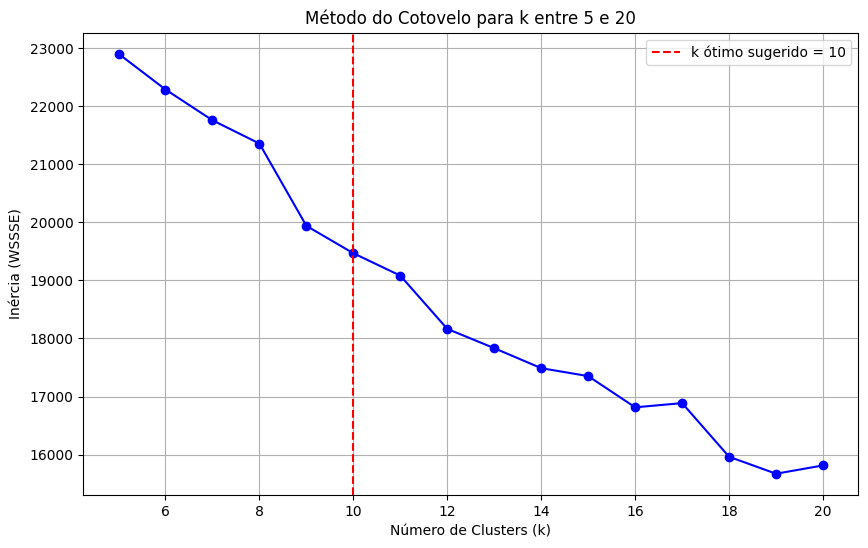


O número ótimo de clusters sugerido pelo método do cotovelo (dentro do range [5-20]) é: 10
Lembre-se que esta é uma sugestão. Você pode querer escolher outro valor de K com base no gráfico ou conhecimento do domínio.
Removendo data_prep_filtered do cache.

✅ Pipeline de ML configurado com 5 estágios.
   Tokenizer Input: objeto_aquisicao, Output: palavras_tokenizadas
   StopWordsRemover Input: palavras_tokenizadas, Output: palavras_sem_stopwords
   Filtrador Personalizado Input: palavras_sem_stopwords, Output: palavras_filtradas_personalizadas
   Word2Vec Input: palavras_filtradas_personalizadas, Output: features_w2v, VectorSize: 50
   KMeans Input: features_w2v, Output: id_cluster, K: 10, InitSteps: 2, MaxIter: 15

--- Célula 13: Configuração do Pipeline de ML Concluída ---


In [ ]:
# Célula 13: Configuração do Pipeline de Machine Learning

print("--- Célula 13: Iniciando Configuração do Pipeline de ML ---")

from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.storagelevel import StorageLevel # Importar StorageLevel
import re
import matplotlib.pyplot as plt
import numpy as np


# Definir classe personalizada de Transformer
class PalavrasRelevantes(Transformer):
    def __init__(self, inputCol="palavras_tokenizadas", outputCol="palavras_filtradas_personalizadas"):
        super(PalavrasRelevantes, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        def filtrar(palavras):
            if palavras is None:
                return []
            return [p for p in palavras if len(p) >= 3 and not re.fullmatch(r"\d+", p)]

        filtrar_udf = udf(filtrar, ArrayType(StringType()))
        return dataset.withColumn(self.outputCol, filtrar_udf(dataset[self.inputCol]))

# Etapa 1: Tokenizer
tokenizer = Tokenizer(inputCol="objeto_aquisicao", outputCol="palavras_tokenizadas")

# Etapa 2: StopWordsRemover
try:
    stopwords_pt
except NameError:
    print("A variável 'stopwords_pt' não estava definida. Carregando stopwords padrão para português.")
    from pyspark.ml.feature import StopWordsRemover as SWRemover_loader
    stopwords_pt = SWRemover_loader.loadDefaultStopWords("portuguese")

remover = StopWordsRemover(
    inputCol="palavras_tokenizadas",
    outputCol="palavras_sem_stopwords",
    stopWords=stopwords_pt,
    caseSensitive=False
)

# Etapa 3: Transformer personalizado
filtrador_personalizado = PalavrasRelevantes(
    inputCol="palavras_sem_stopwords",
    outputCol="palavras_filtradas_personalizadas"
)

# Etapa 4: Word2Vec
vector_size_w2v = 50
min_count_w2v = 3
window_size_w2v = 4
num_partitions_w2v = 16 # Ajuste conforme o tamanho do seu dataset e cluster

word2Vec = Word2Vec(
    vectorSize=vector_size_w2v,
    minCount=min_count_w2v,
    windowSize=window_size_w2v,
    numPartitions=num_partitions_w2v,
    inputCol="palavras_filtradas_personalizadas",
    outputCol="features_w2v",
    seed=42,
    maxIter=5
)

# Montar o Pipeline até Word2Vec para preparar os dados
pipeline_prep = Pipeline(stages=[
    tokenizer,
    remover,
    filtrador_personalizado,
    word2Vec
])

try:
    df_for_clustering
except NameError:
    print("A variável 'df_for_clustering' não estava definida. Criando um DataFrame de exemplo.")
    from pyspark.sql import SparkSession
    # Garante que a sessão Spark seja obtida ou criada
    spark_session_obj = SparkSession.builder.appName("KMeansExampleOptimized").getOrCreate()
    data_exemplar = [
        (1, "Este é o primeiro objeto para processamento de texto e clusterização"), (2, "Um segundo item com palavras diferentes para testar o pipeline"),
        (3, "Processamento de linguagem natural é interessante para análise de dados"), (4, "Mais um exemplo de texto para o modelo de machine learning"),
        (5, "Clusterização de documentos com pyspark ml é o objetivo"), (6, "Análise de texto e agrupamento de palavras chave"),
        (7, "Outro texto para aumentar o volume de dados para o teste"), (8, "Palavras e mais palavras para formar os clusters"),
        (9, "Testando o pipeline com dados de exemplo"), (10, "Otimização do k no kmeans usando o método do cotovelo"),
        (11, "Mais dados para garantir que k=5 e k=6 possam ser testados"), (12, "Ainda mais dados para o teste de clusterização"),
        (13, "Exemplo adicional de texto"), (14, "Outro exemplo para o algoritmo"), (15, "Finalizando os dados de exemplo para ter mais linhas")
    ]
    df_for_clustering = spark_session_obj.createDataFrame(data_exemplar, ["id_doc", "objeto_aquisicao"])

dataset = df_for_clustering

# Ajustar o pipeline de preparação
model_prep = pipeline_prep.fit(dataset)
data_prep = model_prep.transform(dataset)

data_prep_filtered = data_prep.filter(data_prep.features_w2v.isNotNull())

num_amostras_para_kmeans = data_prep_filtered.count() # Contagem feita uma vez

if num_amostras_para_kmeans == 0:
    print("❌ ERRO: Nenhum dado com features_w2v válidas após a preparação.")
    # dbutils.notebook.exit("Falha na preparação de dados para KMeans.")

# OTIMIZAÇÃO: Colocar o DataFrame em cache antes do loop de cálculo da inércia
print(f"Colocando data_prep_filtered ({num_amostras_para_kmeans} linhas) em cache...")
data_prep_filtered.persist(StorageLevel.MEMORY_AND_DISK) # Use MEMORY_AND_DISK para datasets maiores

# Função para calcular a inércia (WSSSE) para diferentes valores de k
def compute_inertia(data, k_values_list): # Parâmetro renomeado para evitar conflito de escopo
    inertias = []
    total_k = len(k_values_list)


    for i, k_val in enumerate(k_values_list):
        print(f"Calculando inércia para k={k_val} ({i+1}/{total_k})...")

        kmeans_eval = KMeans(
            featuresCol="features_w2v",
            predictionCol="id_cluster_eval",
            k=k_val,
            seed=42,
            initSteps=2,
            maxIter=15,
            tol=1e-2
        )


        try:
            model_eval = kmeans_eval.fit(data) # 'data' aqui é o data_prep_filtered
            wssse = model_eval.summary.trainingCost
            inertias.append(wssse)
            print(f"Inércia para k={k_val}: {wssse}")
        except Exception as e:
            print(f"❌ ERRO ao treinar KMeans para k={k_val}: {e}. Pulando este valor de k.")
            inertias.append(float('nan'))

    return inertias


# Defina aqui os valores mínimo e máximo de K que você deseja testar
K_MINIMO_USUARIO = 5
K_MAXIMO_USUARIO = 20

k_valores_para_teste = []
best_k = 5  # Valor de fallback padrão para best_k

if num_amostras_para_kmeans == 0:
    print("❌ ERRO: data_prep_filtered está vazio. Não é possível executar o KMeans.")
    best_k = 1 # Define um k que não quebra o KMeans, embora não vá treinar efetivamente.
elif num_amostras_para_kmeans == 1:
    print("⚠️ AVISO: Apenas 1 ponto de dado em data_prep_filtered. O valor de K será 1.")
    best_k = 1
else: # num_amostras_para_kmeans > 1
    # Validar K_MINIMO_USUARIO
    k_min_para_teste = K_MINIMO_USUARIO
    if K_MINIMO_USUARIO < 2:
        print(f"⚠️ AVISO: K_MINIMO_USUARIO ({K_MINIMO_USUARIO}) é menor que 2. Ajustando para 2.")
        k_min_para_teste = 2

    # Validar K_MAXIMO_USUARIO
    k_max_para_teste = K_MAXIMO_USUARIO
    if K_MAXIMO_USUARIO > num_amostras_para_kmeans:
        print(f"⚠️ AVISO: K_MAXIMO_USUARIO ({K_MAXIMO_USUARIO}) é maior que o número de amostras válidas ({num_amostras_para_kmeans}). Ajustando para {num_amostras_para_kmeans}.")
        k_max_para_teste = num_amostras_para_kmeans

    if k_min_para_teste > k_max_para_teste:
        print(f"❌ ERRO DE CONFIGURAÇÃO: K mínimo para teste ({k_min_para_teste}) é maior que K máximo para teste ({k_max_para_teste}).")
        print(f"Não será possível executar o método do cotovelo. Usando k={best_k} (fallback) ou ajuste K_MINIMO_USUARIO e K_MAXIMO_USUARIO.")
        # Mantém best_k com o valor de fallback (ex: 5) ou o menor k possível (2 ou k_max_para_teste se válido)
        if k_max_para_teste >= 2 : # Se o k_max_para_teste for um valor válido, podemos usá-lo.
             best_k = k_max_para_teste
             print(f"Ajustando best_k para {best_k} com base no k_max_para_teste.")
        else: # Senão, usa o default (2, pois num_amostras_para_kmeans > 1)
             best_k = 2
             print(f"Ajustando best_k para {best_k} como default seguro.")
        k_valores_para_teste = [] # Garante que o loop do cotovelo não rode
    else:
        k_valores_para_teste = list(range(k_min_para_teste, k_max_para_teste + 1))

# Executar o método do cotovelo se houver um range válido de K e dados suficientes
if num_amostras_para_kmeans > 1 and len(k_valores_para_teste) > 0:
    print(f"Iniciando cálculo de inércias para k de {min(k_valores_para_teste)} a {max(k_valores_para_teste)} (definido pelo usuário).")

    inertias = compute_inertia(data_prep_filtered, k_valores_para_teste)

    valid_inertias_indices = [i for i, x in enumerate(inertias) if x is not None and not np.isnan(x)]

    if not valid_inertias_indices:
        print("❌ ERRO: Não foi possível calcular inércias válidas para o range de K fornecido.")
        print(f"Usando k={best_k} (fallback ou k mínimo/máximo ajustado anteriormente).")
        # best_k já terá sido definido em caso de erro de range ou será o fallback inicial.
    else:
        valid_k_values = [k_valores_para_teste[i] for i in valid_inertias_indices]
        valid_inertias = [inertias[i] for i in valid_inertias_indices]

        if not valid_k_values or not valid_inertias:
            print("❌ ERRO: Listas de k_values ou inertias válidas estão vazias após filtragem.")
            print(f"Usando k={best_k} (fallback ou k mínimo/máximo ajustado anteriormente).")
        else:
            def find_elbow_point(k_vals, inertia_vals):
                if len(k_vals) < 2:
                    print("⚠️ AVISO: Menos de dois pontos k válidos no range testado. Retornando o primeiro k válido.")
                    return k_vals[0]
                if len(k_vals) == 2:
                    print("⚠️ AVISO: Apenas dois valores de k válidos no range testado. Método do cotovelo não aplicável de forma robusta. Retornando o primeiro k válido.")
                    return k_vals[0]

                deltas = np.diff(inertia_vals)
                deltas_deltas = np.diff(deltas)

                if len(deltas_deltas) == 0:
                    print("⚠️ AVISO: Não foi possível calcular a segunda derivada das inércias (ex: apenas 2 k's válidos). Retornando o primeiro k válido.")
                    return k_vals[0]

                elbow_idx = np.argmax(deltas_deltas)
                return k_vals[elbow_idx + 2]

            k_sugerido_cotovelo = find_elbow_point(np.array(valid_k_values), np.array(valid_inertias))
            best_k = k_sugerido_cotovelo # Atualiza best_k com a sugestão do cotovelo

            plt.figure(figsize=(10, 6))
            plt.plot(valid_k_values, valid_inertias, 'bo-')
            plt.xlabel('Número de Clusters (k)')
            plt.ylabel('Inércia (WSSSE)')
            plt.title(f'Método do Cotovelo para k entre {min(valid_k_values)} e {max(valid_k_values)}')
            plt.axvline(x=best_k, color='r', linestyle='--', label=f'k ótimo sugerido = {best_k}')
            plt.legend()
            plt.grid(True)
            plt.show()

            print(f"\nO número ótimo de clusters sugerido pelo método do cotovelo (dentro do range [{min(valid_k_values)}-{max(valid_k_values)}]) é: {best_k}")
            print(f"Lembre-se que esta é uma sugestão. Você pode querer escolher outro valor de K com base no gráfico ou conhecimento do domínio.")
elif num_amostras_para_kmeans > 1 and len(k_valores_para_teste) == 0 :
    # Este caso ocorre se K_MINIMO_USUARIO e K_MAXIMO_USUARIO resultaram em um range inválido
    print(f"⚠️ AVISO: Método do cotovelo não executado devido a um range de K inválido. Usando k={best_k} (definido anteriormente).")
else: # num_amostras_para_kmeans <=1
     print(f"⚠️ AVISO: Método do cotovelo não executado. Número de amostras: {num_amostras_para_kmeans}. Usando k={best_k}.")


print("Removendo data_prep_filtered do cache.")
data_prep_filtered.unpersist()

# Configurar o KMeans com o k ótimo encontrado e parâmetros mais robustos para o modelo final
numero_de_clusters_kmeans = best_k # best_k é o resultado da lógica acima
init_steps_kmeans = 2
max_iter_kmeans = 15

# Garantia final: k não pode ser zero ou negativo. E se dataset for vazio, k=1 é um placeholder.
if numero_de_clusters_kmeans <= 0:
    print(f"⚠️ Alerta: numero_de_clusters_kmeans ({numero_de_clusters_kmeans}) é inválido. Ajustando para 1.")
    numero_de_clusters_kmeans = 1

# Se o dataset original (antes do data_prep_filtered) for relevante para o K final.
# A lógica atual baseia K em num_amostras_para_kmeans (data_prep_filtered.count()).
# Se dataset.count() for 0, KMeans não deve ser treinado.
original_dataset_count = dataset.count()
if original_dataset_count == 0:
    print("❌ ERRO: O DataFrame 'dataset' original está vazio. O pipeline não será treinado.")
    # Neste ponto, talvez seja melhor não prosseguir com a configuração do KMeans e Pipeline.
    # No entanto, para evitar quebrar o fluxo, pode-se definir um K padrão.
    numero_de_clusters_kmeans = 1
elif numero_de_clusters_kmeans > original_dataset_count and original_dataset_count > 0:
    # Esta é uma checagem adicional, pois KMeans pode falhar se k > número de linhas no dataset que ele vai FITar.
    # No entanto, o pipeline.fit(dataset) usa 'dataset', não 'data_prep_filtered'.
    # A lógica de K foi baseada em data_prep_filtered. Se houver uma grande discrepância, pode ser um problema.
    print(f"⚠️ AVISO: O K final ({numero_de_clusters_kmeans}) é maior que o número de linhas no 'dataset' original ({original_dataset_count}).")
    print("Isso pode ser problemático se muitas linhas foram filtradas em 'data_prep_filtered'.")
    print("Considere ajustar K manualmente ou verificar a etapa de preparação de dados.")
    # Não vamos alterar K aqui automaticamente, pois a intenção é seguir o 'best_k' da análise.


kmeans = KMeans(
    featuresCol="features_w2v",
    predictionCol="id_cluster",
    k=numero_de_clusters_kmeans,
    seed=42,
    initSteps=init_steps_kmeans,
    maxIter=max_iter_kmeans,
    distanceMeasure="cosine"
)

pipeline_stages = [
    tokenizer,
    remover,
    filtrador_personalizado,
    word2Vec,
    kmeans
]
pipeline = Pipeline(stages=pipeline_stages)

if pipeline and pipeline.getStages():
    print(f"\n✅ Pipeline de ML configurado com {len(pipeline.getStages())} estágios.")
    print(f"   Tokenizer Input: {tokenizer.getInputCol()}, Output: {tokenizer.getOutputCol()}")
    print(f"   StopWordsRemover Input: {remover.getInputCol()}, Output: {remover.getOutputCol()}")
    print(f"   Filtrador Personalizado Input: {filtrador_personalizado.inputCol}, Output: {filtrador_personalizado.outputCol}")
    print(f"   Word2Vec Input: {word2Vec.getInputCol()}, Output: {word2Vec.getOutputCol()}, VectorSize: {word2Vec.getVectorSize()}")
    print(f"   KMeans Input: {kmeans.getFeaturesCol()}, Output: {kmeans.getPredictionCol()}, K: {kmeans.getK()}, InitSteps: {kmeans.getInitSteps()}, MaxIter: {kmeans.getMaxIter()}")
else:
    print("❌ ERRO: Falha ao configurar o Pipeline de ML.")

print("\n--- Célula 13: Configuração do Pipeline de ML Concluída ---")


In [ ]:
print("--- Célula 14: Iniciando Treinamento com Pipeline Separado ---")

from pyspark.ml.clustering import KMeansModel

# Etapa 1: Preparar os dados com o pipeline_prep já definido
print("Aplicando pipeline de preparação (até Word2Vec)...")
model_prep = pipeline_prep.fit(df_for_clustering)
data_prep = model_prep.transform(df_for_clustering)

# Etapa 2: Filtrar registros com embeddings válidos
data_prep_filtered = data_prep.filter(F.col("features_w2v").isNotNull())

# Etapa 3: Verificar se há dados suficientes
num_validos = data_prep_filtered.count()
print(f"Registros com 'features_w2v' válidas: {num_validos}")

if num_validos == 0:
    print("❌ ERRO: Nenhum dado com embeddings válidos após preparação. Abortando.")
    dbutils.notebook.exit("Falha no treinamento.")
elif best_k > num_validos:
    print(f"⚠️ AVISO: Número de clusters (k={best_k}) maior que número de registros válidos ({num_validos}). Ajustando k para {num_validos}.")
    best_k = num_validos if num_validos > 0 else 1

# Etapa 4: Criar o modelo de KMeans com o K ótimo
print(f"Treinando modelo KMeans com k={best_k}...")
kmeans = KMeans(
    featuresCol="features_w2v",
    predictionCol="id_cluster",
    k=best_k,
    seed=42,
    initSteps=init_steps_kmeans,
    maxIter=max_iter_kmeans
)

kmeans_model = kmeans.fit(data_prep_filtered)
print("✅ KMeans treinado com sucesso.")

# Etapa 5: Transformar os dados e gerar df_clustered
df_clustered = kmeans_model.transform(data_prep_filtered)
print("✅ Dados transformados com KMeans e 'id_cluster' atribuído.")

# Validar a existência das colunas esperadas
if "id_cluster" in df_clustered.columns and "features_w2v" in df_clustered.columns:
    df_clustered.select("objeto_aquisicao", "features_w2v", "id_cluster").show(5, truncate=50)
else:
    print("❌ ERRO: Colunas esperadas não encontradas após transformação.")
    df_clustered.printSchema()
    dbutils.notebook.exit("Falha na transformação final.")


--- Célula 14: Iniciando Treinamento com Pipeline Separado ---
Aplicando pipeline de preparação (até Word2Vec)...
Registros com 'features_w2v' válidas: 13137
Treinando modelo KMeans com k=10...
✅ KMeans treinado com sucesso.
✅ Dados transformados com KMeans e 'id_cluster' atribuído.
+--------------------------------------------------+--------------------------------------------------+----------+
|                                  objeto_aquisicao|                                      features_w2v|id_cluster|
+--------------------------------------------------+--------------------------------------------------+----------+
|tendo em vista instalacao de portico detector d...|[0.1898281779140234,-0.033061094814911485,-0.19...|         0|
|tintas para pintura das portas corta fogo do te...|[0.318824277104189,-0.050458982276419796,0.1224...|         0|
|                             eliminacao de aranhas|[0.20655880123376846,-0.0760605800896883,-0.097...|         0|
|em virtude da necessidade

In [ ]:
print("--- Célula 15: Iniciando Transformação dos Dados e Atribuição de Clusters ---")

# Esta célula já está implicitamente resolvida com a nova lógica:
# df_clustered = kmeans_model.transform(data_prep_filtered)

# Verificações de consistência
if df_clustered is not None and "id_cluster" in df_clustered.columns:
    print("✅ Dados já transformados e coluna 'id_cluster' presente no DataFrame.")
    df_clustered.select("objeto_aquisicao", "id_cluster").show(5, truncate=80)
else:
    print("❌ ERRO: DataFrame 'df_clustered' está nulo ou incompleto. Verifique a etapa anterior.")
    dbutils.notebook.exit("Falha na transformação com KMeans.")

print("\n--- Célula 15 concluída ---")


--- Célula 15: Iniciando Transformação dos Dados e Atribuição de Clusters ---
✅ Dados já transformados e coluna 'id_cluster' presente no DataFrame.
+--------------------------------------------------------------------------------+----------+
|                                                                objeto_aquisicao|id_cluster|
+--------------------------------------------------------------------------------+----------+
|necessario para suprir falta de entrega dos insumos pela empresa morada prest...|         3|
|necessario para suprir falta de entrega dos insumos pela empresa morada prest...|         3|
|necessario para suprir falta de entrega dos insumos pela empresa morada prest...|         3|
|agua mineral em galao de 20 litros nao foi concluido o termo de licitacao em ...|         0|
|                             reposicao de telefones para os gabinetes e cartorio|         4|
+--------------------------------------------------------------------------------+----------+
only s

--- Célula 16: Análise e Visualização dos Resultados ---
✅ DataFrame 'df_clustered' em cache.

Contagem de registros por cluster:
+----------+-----+
|id_cluster|count|
+----------+-----+
|0         |2946 |
|1         |419  |
|2         |859  |
|3         |1667 |
|4         |3547 |
|5         |366  |
|6         |1654 |
|7         |411  |
|8         |1058 |
|9         |210  |
+----------+-----+


Gerando gráfico de contagem por cluster...


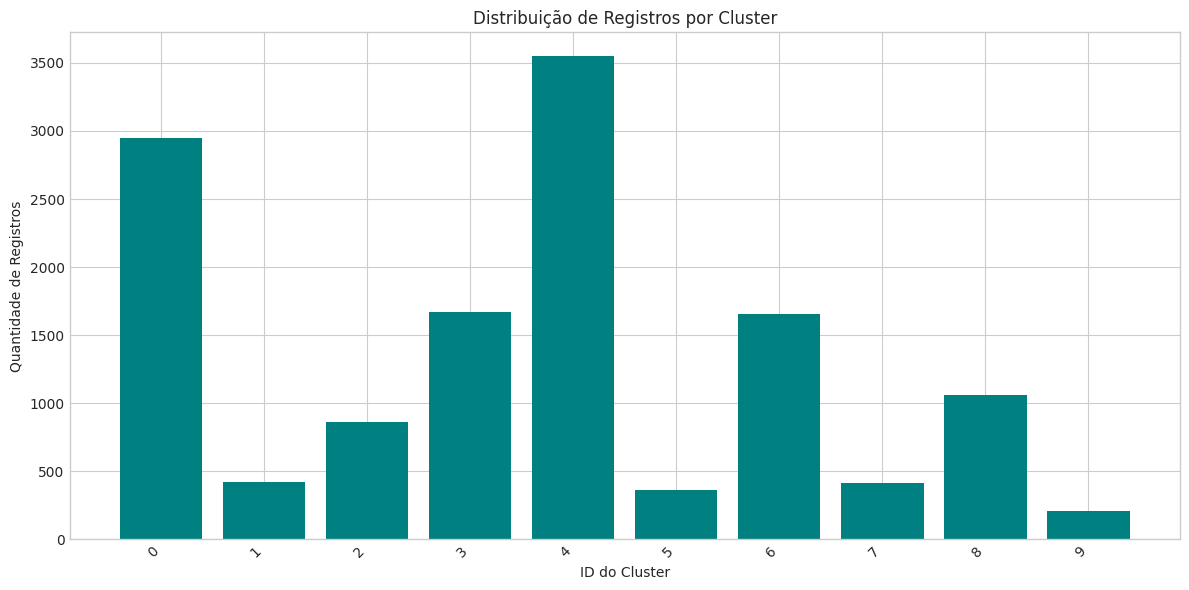


Amostras de 'objeto_aquisicao' por cluster (até 3 exemplos por cluster):

--- Cluster 0 ---
+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                        objeto_aquisicao|
+------------------------------------------------------------------------------------------------------------------------+
|tendo em vista instalacao de portico detector de metais no ambito da prm nh teremos que adquirir por meio do cartao d...|
|                                                                     tintas para pintura das portas corta fogo do terreo|
|                                                                                                   eliminacao de aranhas|
+------------------------------------------------------------------------------------------------------------------------+


--- Cluster 1 ---
+-------------------------

In [ ]:
print("--- Célula 16: Análise e Visualização dos Resultados ---")

from pyspark.sql import functions as F

# Importar bibliotecas para visualização
import matplotlib.pyplot as plt
import pandas as pd

# Configurações de estilo para os gráficos (opcional)
plt.style.use('seaborn-v0_8-whitegrid')

if df_clustered is not None:
    # Cache para performance (mantenha, é uma boa prática antes de múltiplas operações)
    df_clustered.cache()
    print("✅ DataFrame 'df_clustered' em cache.")

    # --- 1. Contagem por cluster ---
    print("\nContagem de registros por cluster:")
    contagem_por_cluster = df_clustered.groupBy("id_cluster").count().orderBy("id_cluster")
    contagem_por_cluster.show(truncate=False)

    # --- Visualização da Contagem por Cluster ---
    print("\nGerando gráfico de contagem por cluster...")
    try:
        # Coletar os dados para um Pandas DataFrame.
        # É seguro fazer isso aqui porque contagem_por_cluster tem poucas linhas (uma por cluster).
        contagem_por_cluster_pd = contagem_por_cluster.toPandas()

        # Criar o gráfico de barras
        plt.figure(figsize=(12, 6)) # Define o tamanho da figura
        plt.bar(contagem_por_cluster_pd['id_cluster'].astype(str), contagem_por_cluster_pd['count'], color='teal')

        plt.xlabel("ID do Cluster")
        plt.ylabel("Quantidade de Registros")
        plt.title("Distribuição de Registros por Cluster")
        plt.xticks(rotation=45, ha='right') # Rotaciona os labels do eixo X se houver muitos clusters
        plt.tight_layout() # Ajusta o layout para evitar sobreposição

        # Exibir o gráfico
        # Em ambientes como Databricks, pode ser necessário usar display(plt.gcf())
        # Em ambientes locais (Jupyter, etc.), plt.show() funciona
        plt.show()

    except Exception as e:
        print(f"❌ ERRO ao gerar o gráfico de contagem por cluster: {e}")
        print("Certifique-se de que 'matplotlib' e 'pandas' estão instalados.")


    # --- 2. Amostras por cluster ---
    print("\nAmostras de 'objeto_aquisicao' por cluster (até 3 exemplos por cluster):")

    # Coletar os IDs dos clusters para iterar (seguro pois contagem_por_cluster é pequeno)
    cluster_ids = [row.id_cluster for row in contagem_por_cluster.select("id_cluster").collect()]

    for cid in cluster_ids:
        print(f"\n--- Cluster {cid} ---")
        # Filtrar o DataFrame PySpark original (não o Pandas) para obter amostras
        exemplos = df_clustered.filter(F.col("id_cluster") == cid)
        if "objeto_aquisicao" in exemplos.columns:
            # Usar .limit(3) para obter no máximo 3 exemplos
            exemplos.select("objeto_aquisicao").limit(3).show(truncate=120)
        else:
            print("⚠️ Coluna 'objeto_aquisicao' não disponível. Mostrando outras colunas possíveis.")
            # Excluir colunas binárias ou complexas que podem não exibir bem
            colunas_disponiveis = [c for c in exemplos.columns if c not in ['features_w2v', 'id_cluster'] and not isinstance(exemplos.schema[c].dataType, (F.BinaryType, F.ArrayType, F.MapType))]
            # Mostrar as primeiras 2 colunas disponíveis (limitando a 3 linhas)
            exemplos.select(colunas_disponiveis[:2]).limit(3).show(truncate=120) # Use limit(3) aqui também
else:
    print("❌ ERRO: DataFrame 'df_clustered' não está disponível.")

--- Célula 17: Análise Visual dos Clusters com PCA ---
✅ DataFrame 'df_clustered' em cache.
Aplicando PCA nos vetores 'features_w2v' de 13137 registros...


Coletando dados PCA para visualização (pode consumir memória para grandes datasets)...


/root/.ipykernel/1167/command-3111877067695452-245445471:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", max(num_unique_clusters, 1)) # Garante pelo menos 1 cor se não houver clusters


✅ Dados preparados. Gerando gráficos individuais por cluster...


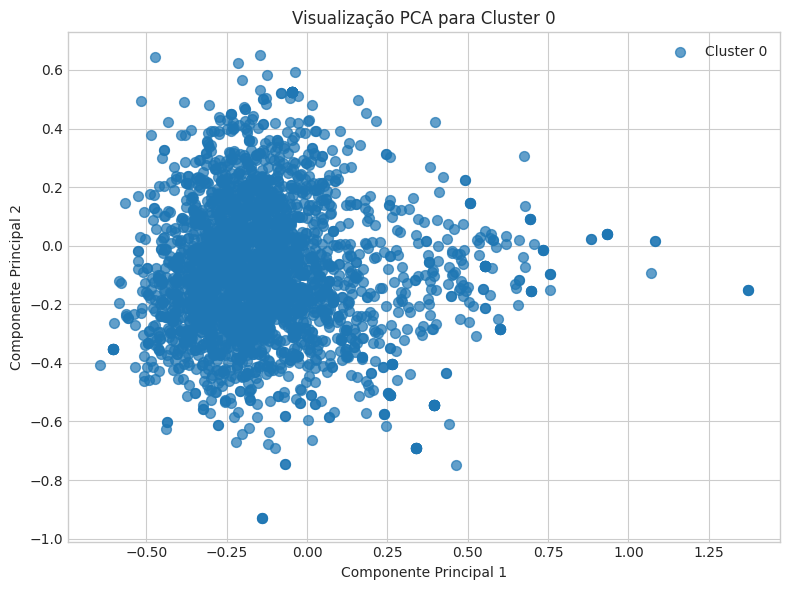

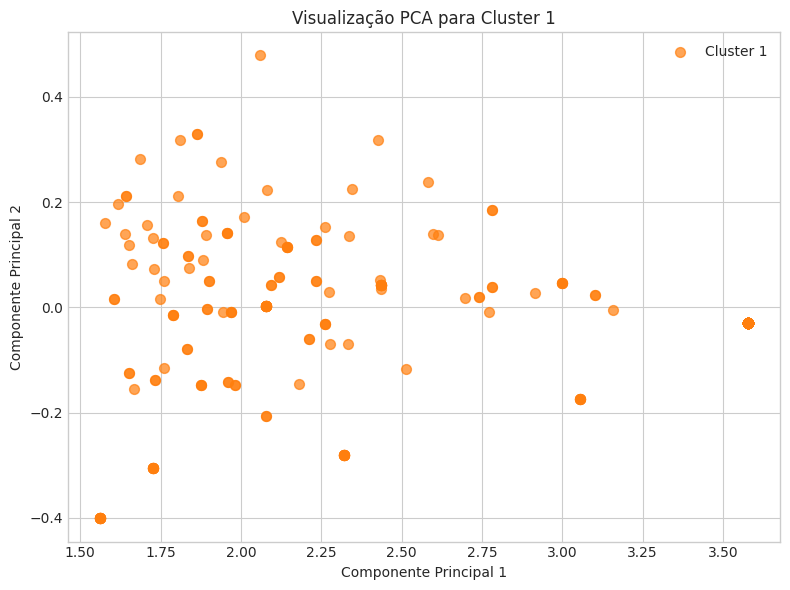

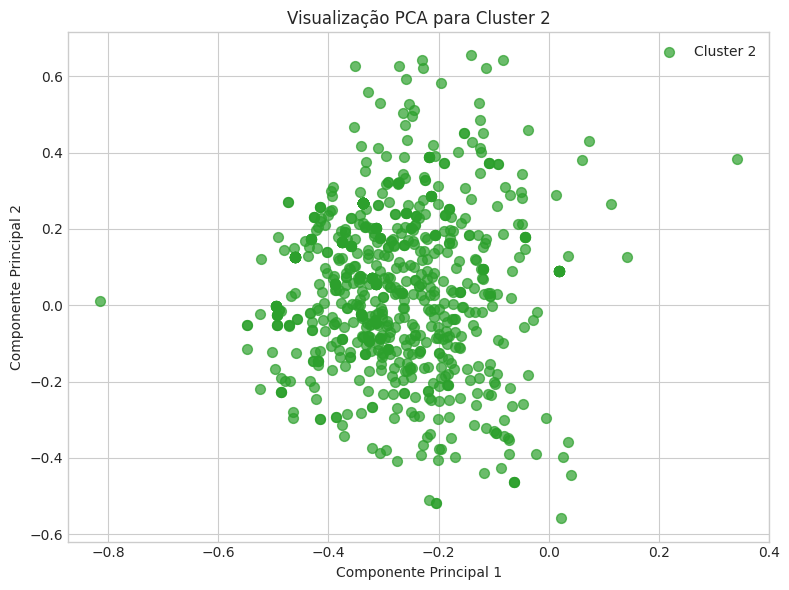

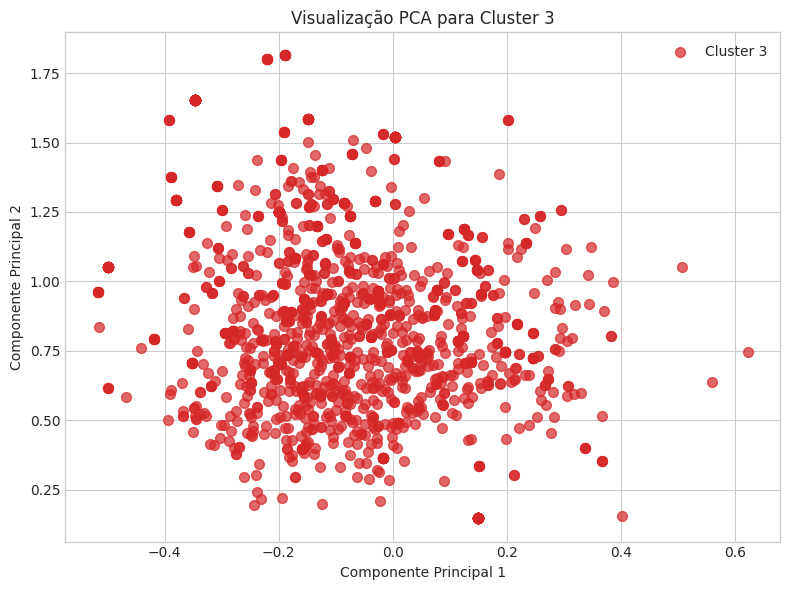

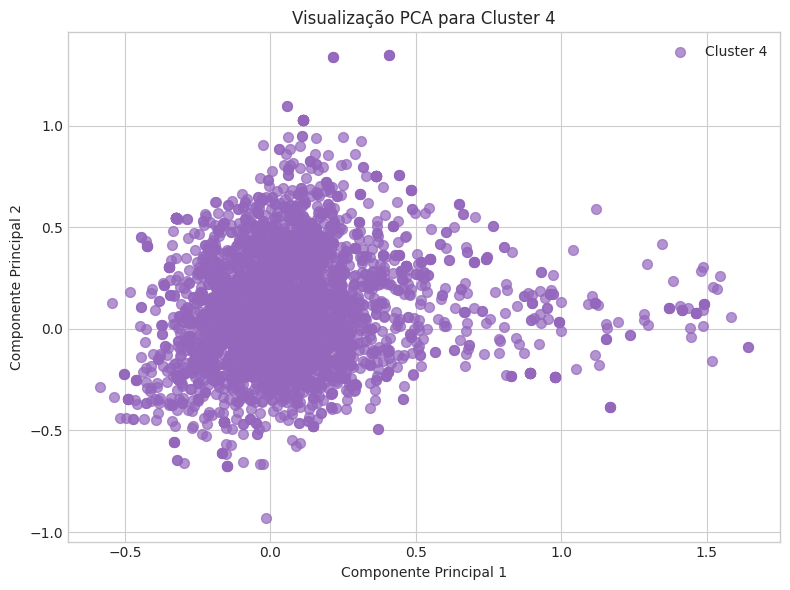

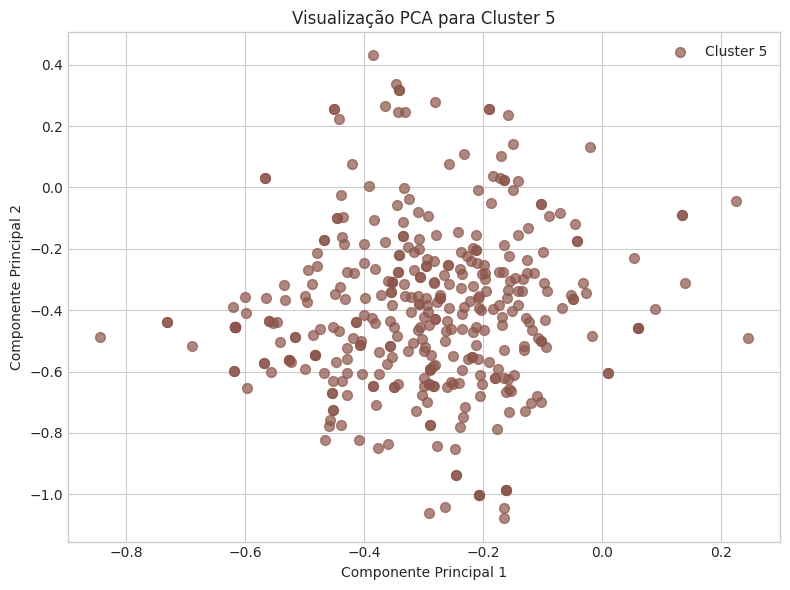

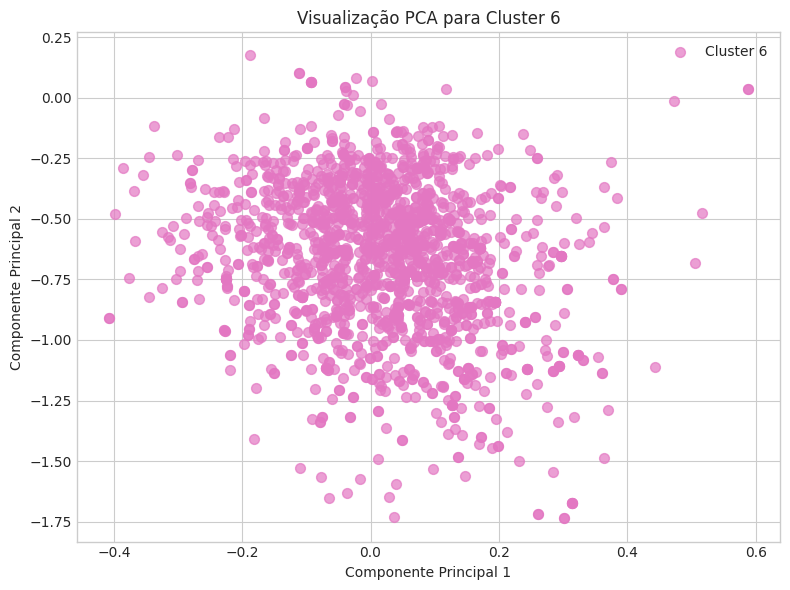

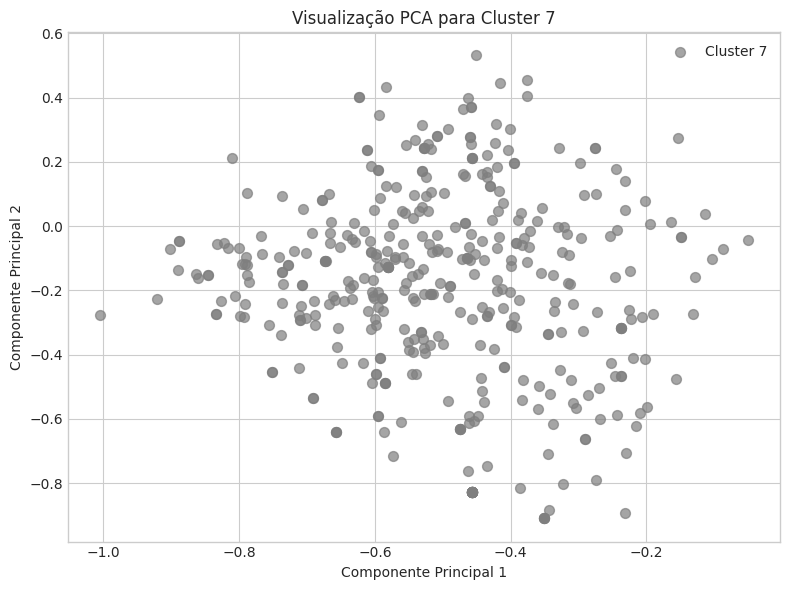

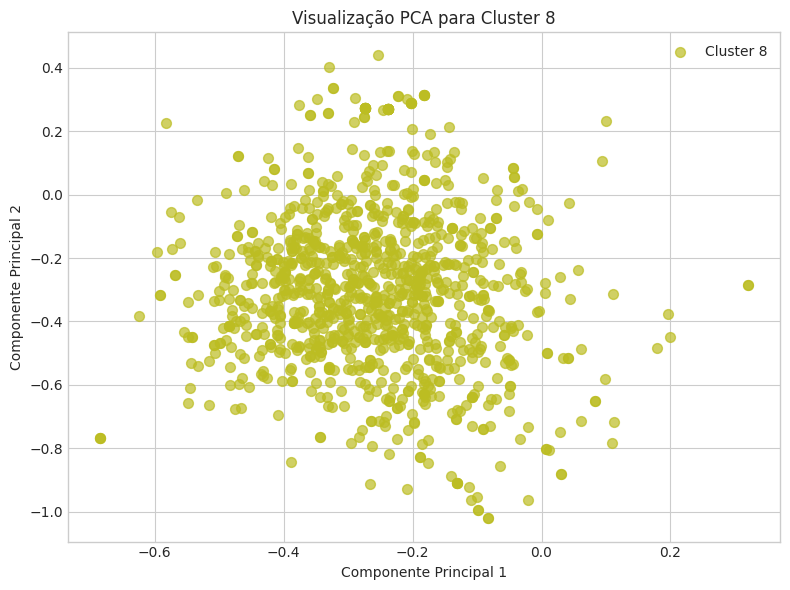

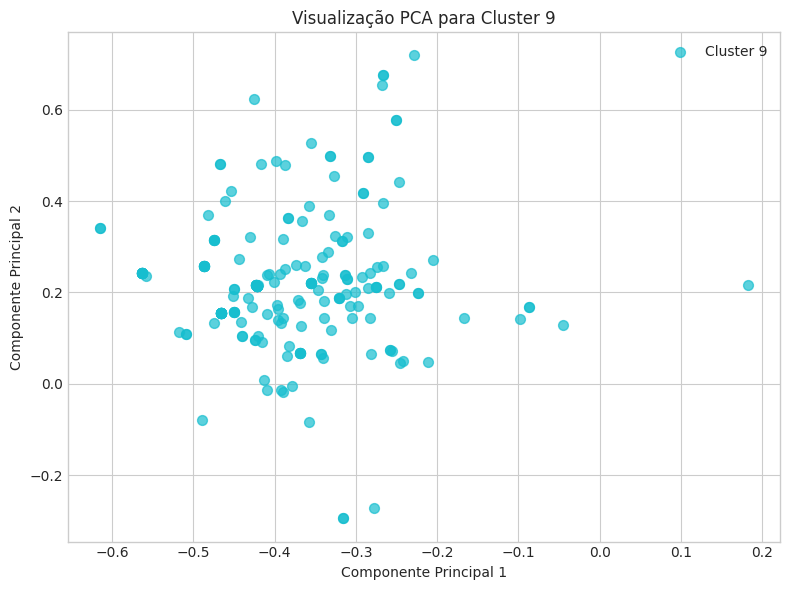


Gerando gráfico combinado para todos os clusters...


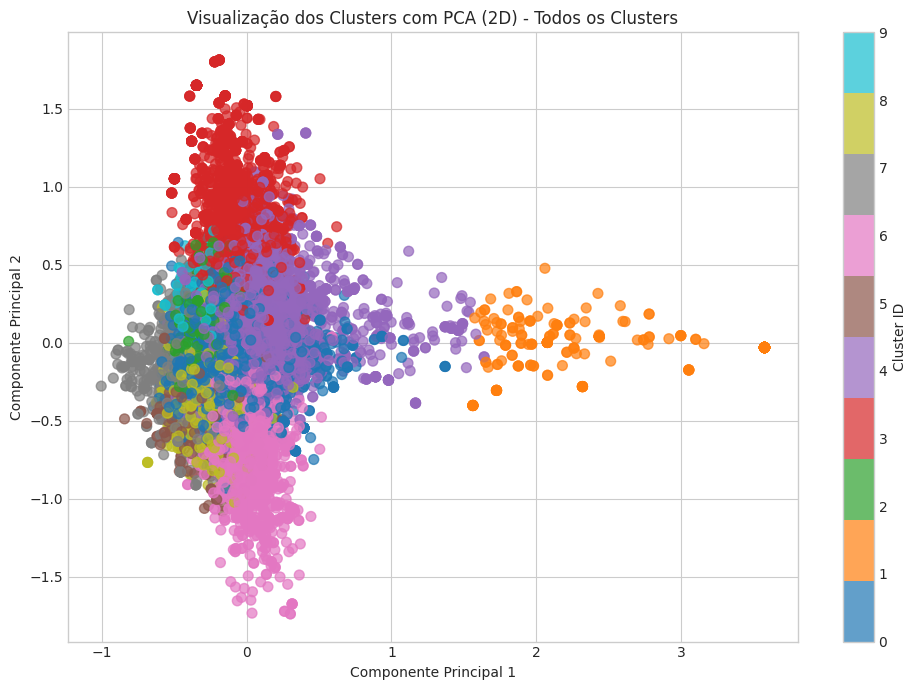

In [ ]:
print("--- Célula 17: Análise Visual dos Clusters com PCA ---")

from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm # Para mapas de cores
import pandas as pd # Precisaremos de Pandas para facilitar a filtragem

if df_clustered is not None:
    df_clustered.cache()
    print("✅ DataFrame 'df_clustered' em cache.")

    # --- 1. Verificar se há dados suficientes para aplicar PCA ---
    num_registros = df_clustered.count()
    if num_registros < 2:
        print(f"⚠️ Número insuficiente de registros ({num_registros}) para aplicar PCA.")
    else:
        # --- 2. Aplicar PCA para reduzir de 50D para 2D ---
        print(f"Aplicando PCA nos vetores 'features_w2v' de {num_registros} registros...")
        try:
            pca = PCA(k=2, inputCol="features_w2v", outputCol="features_pca")
            pca_model = pca.fit(df_clustered)
            # Selecionar as colunas de interesse após a transformação
            df_pca = pca_model.transform(df_clustered).select("features_pca", "id_cluster")

            # --- 3. Coletar os dados para visualização ---
            # CUIDADO: .collect() traz todos os dados para a memória do driver.
            # Se o número de registros for muito grande, isso pode causar OutOfMemoryError.
            # Para grandes datasets, considere amostrar antes de coletar:
            # df_pca_sampled = df_pca.sample(False, 0.1, seed=42) # Exemplo: amostra de 10%
            # pca_data = df_pca_sampled.collect()
            print("Coletando dados PCA para visualização (pode consumir memória para grandes datasets)...")
            pca_data = df_pca.collect()

            # Converter para arrays NumPy
            pontos = np.array([row["features_pca"] for row in pca_data])
            clusters = np.array([row["id_cluster"] for row in pca_data])

            if pontos.shape[0] == 0:
                print("❌ Nenhum vetor PCA disponível para plotagem após coleta.")
            else:
                # Converter para Pandas DataFrame para facilitar a filtragem
                df_pca_pd = pd.DataFrame({
                    'pca_component_1': pontos[:, 0],
                    'pca_component_2': pontos[:, 1],
                    'id_cluster': clusters
                })

                # Identificar IDs de cluster únicos e preparar o mapa de cores
                unique_clusters = np.unique(clusters)
                num_unique_clusters = unique_clusters.size
                # Usar um mapa de cores apropriado para o número de clusters
                cmap = cm.get_cmap("tab10", max(num_unique_clusters, 1)) # Garante pelo menos 1 cor se não houver clusters

                print("✅ Dados preparados. Gerando gráficos individuais por cluster...")

                # --- 4. Plotar Gráficos Individuais por Cluster ---
                for i, cid in enumerate(unique_clusters):
                    # Filtrar dados para o cluster atual
                    df_cluster_data = df_pca_pd[df_pca_pd['id_cluster'] == cid]

                    if not df_cluster_data.empty:
                        plt.figure(figsize=(8, 6)) # Define o tamanho da figura para cada gráfico individual
                        # Obter a cor para este cluster a partir do mapa de cores
                        color = cmap(i) # Usa o índice do cluster único para obter a cor

                        plt.scatter(df_cluster_data['pca_component_1'], df_cluster_data['pca_component_2'],
                                    color=color, s=50, alpha=0.7, label=f'Cluster {cid}')

                        plt.xlabel("Componente Principal 1")
                        plt.ylabel("Componente Principal 2")
                        plt.title(f"Visualização PCA para Cluster {cid}")
                        plt.grid(True)
                        plt.legend() # Adiciona a legenda mostrando o ID do cluster
                        plt.tight_layout()
                        plt.show() # Mostra o gráfico para o cluster atual

                # --- 5. Plotar Gráfico Combinado (Todos os Clusters) ---
                print("\nGerando gráfico combinado para todos os clusters...")
                plt.figure(figsize=(10, 7)) # Define o tamanho da figura para o gráfico combinado
                # Reutiliza os arrays NumPy e o mapa de cores criado anteriormente
                scatter = plt.scatter(pontos[:, 0], pontos[:, 1], c=clusters,
                                      cmap=cmap, s=50, alpha=0.7)

                # Adiciona a barra de cores que mapeia cores para IDs de cluster
                # O ticks=range(num_unique_clusters) garante que os ticks da colorbar correspondam aos IDs (se forem 0, 1, 2...)
                # Se os IDs não forem contínuos de 0 em diante, pode ser necessário ajustar os ticks e labels da colorbar.
                # Uma forma mais robusta para ticks é usar os unique_clusters diretamente, mas colorbar tick labels precisam ser strings ou números.
                # Vamos usar os unique_clusters como ticks se o número for pequeno, senão o default da colorbar.
                if num_unique_clusters <= 20: # Limite para não ter muitos ticks
                     cbar = plt.colorbar(scatter, ticks=unique_clusters, label="Cluster ID")
                     # Optional: Ensure ticks are integers if cluster IDs are integers
                     cbar.set_ticks(unique_clusters) # Explicitly set ticks
                     cbar.set_ticklabels([str(int(cid)) for cid in unique_clusters]) # Set labels as strings
                else:
                     plt.colorbar(scatter, label="Cluster ID")


                plt.xlabel("Componente Principal 1")
                plt.ylabel("Componente Principal 2")
                plt.title("Visualização dos Clusters com PCA (2D) - Todos os Clusters")
                plt.grid(True)
                plt.tight_layout()
                plt.show() # Mostra o gráfico combinado

        except Exception as e:
            print(f"❌ ERRO durante o processamento ou plotagem do PCA: {e}")
            import traceback
            print(traceback.format_exc())

else:
    print("❌ ERRO: df_clustered está ausente. Execute as etapas anteriores antes desta visualização.")

In [ ]:
print("--- Célula 18: Iniciando Salvamento do DataFrame Clusterizado (Opcional) ---")

salvar_resultados = True  # Altere para False se não quiser salvar

if salvar_resultados:
    if df_clustered is not None:
        output_path_clustered_data_w2v = "dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final/clusterizado"
        print(f"Salvando DataFrame clusterizado (Word2Vec) em: {output_path_clustered_data_w2v}")
        try:
            colunas_para_salvar = colunas_presentes_no_df_input + ["id_cluster"]
            df_para_salvar = df_clustered.select(*colunas_para_salvar)

            dbutils.fs.rm(output_path_clustered_data_w2v, recurse=True)
            df_para_salvar.write.mode("overwrite").option("compression", "snappy").parquet(output_path_clustered_data_w2v)

            print(f"✅ DataFrame salvo com sucesso em: {output_path_clustered_data_w2v}")
        except Exception as e:
            print(f"❌ ERRO ao salvar: {e}")
            import traceback
            print(traceback.format_exc())
    else:
        print("⚠️ df_clustered não disponível. Nada a salvar.")
else:
    print("Salvamento desativado (salvar_resultados=False).")

print("--- Fim da Célula 18 ---")


--- Célula 18: Iniciando Salvamento do DataFrame Clusterizado (Opcional) ---
Salvando DataFrame clusterizado (Word2Vec) em: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final/clusterizado
✅ DataFrame salvo com sucesso em: dbfs:/FileStore/shared_uploads/gustavoparreira@hotmail.com/analise-a3/Parquet/final/clusterizado
--- Fim da Célula 18 ---


--- Célula 19: Iniciando Detecção de Outliers por Cluster ---
Iniciando detecção de outliers na coluna 'valor'
▶️ Aplicando método IQR...
✅ Outliers detectados com IQR. Mostrando os primeiros 5:
+----------+----------------------------------------------------------------------------------------------------+-----+
|id_cluster|                                                                                    objeto_aquisicao|valor|
+----------+----------------------------------------------------------------------------------------------------+-----+
|         4|considerando a falha da empresa riomix a prm ficou sem papel toalha e foi necessario comprar de e...|518.0|
|         8|                                                          para instalacao nos vestiarios do 2o andar|463.4|
|         9|                                                        compra de gas de cozinha para a prm monteiro|222.0|
|         3|                                      aquisicao de pen drive pra atender 

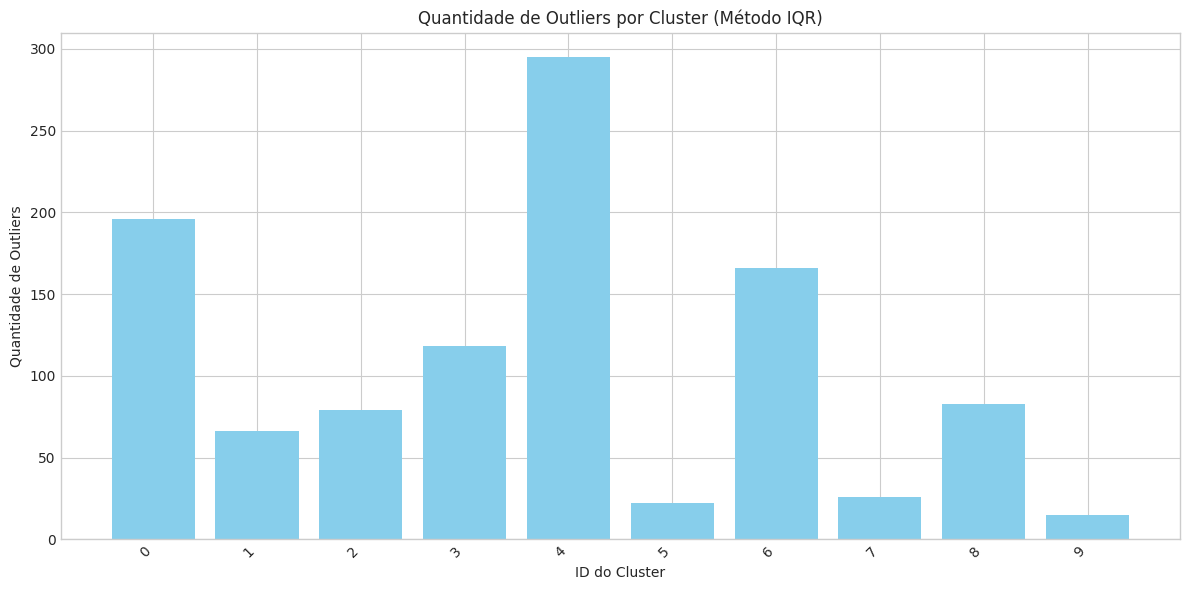


Gerando boxplot por cluster...
Removendo registros com valor nulo ou não positivo na coluna 'valor' para o boxplot...
Removidos 0 registros. Restam 13137 para o boxplot.
Aplicado escala logarítmica ao eixo Y do boxplot.


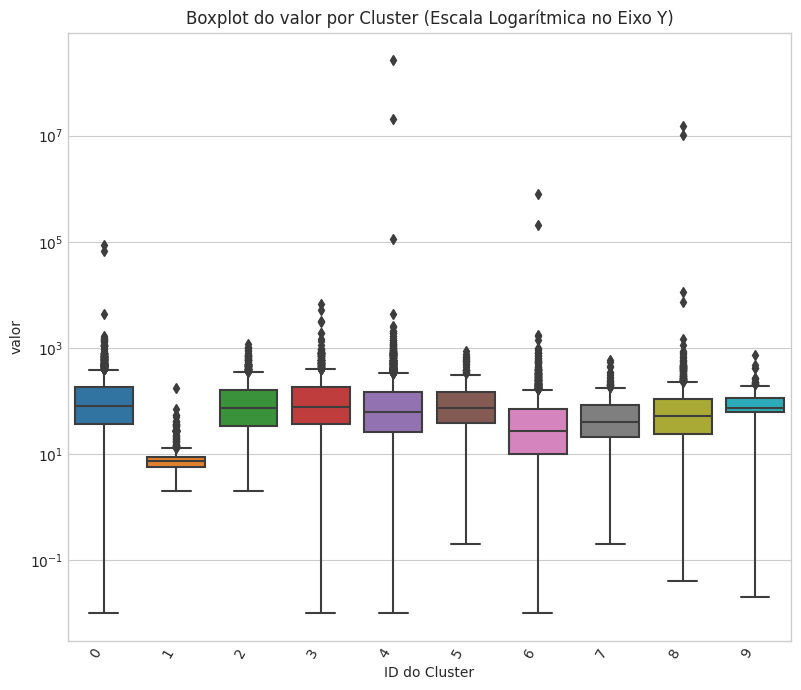


▶️ Aplicando método Z-Score...

▶️ Aplicando método Z-Score...
✅ Outliers detectados com Z-Score. Mostrando os primeiros 5:
+----------+----------------------------------------------------------------------------------------------------+--------+------------------+
|id_cluster|                                                                                    objeto_aquisicao|   valor|            zscore|
+----------+----------------------------------------------------------------------------------------------------+--------+------------------+
|         0|                                                       bateria para aparelho telecomunicador movel 3|66003.36|32.636405884018785|
|         0|                                                       bateria para aparelho telecomunicador movel 4|87002.45| 43.04999808862359|
|         1|                                                  despesas com pagamento de pedagio viagem a servico|   177.4|13.967260746021948|
|         1|           

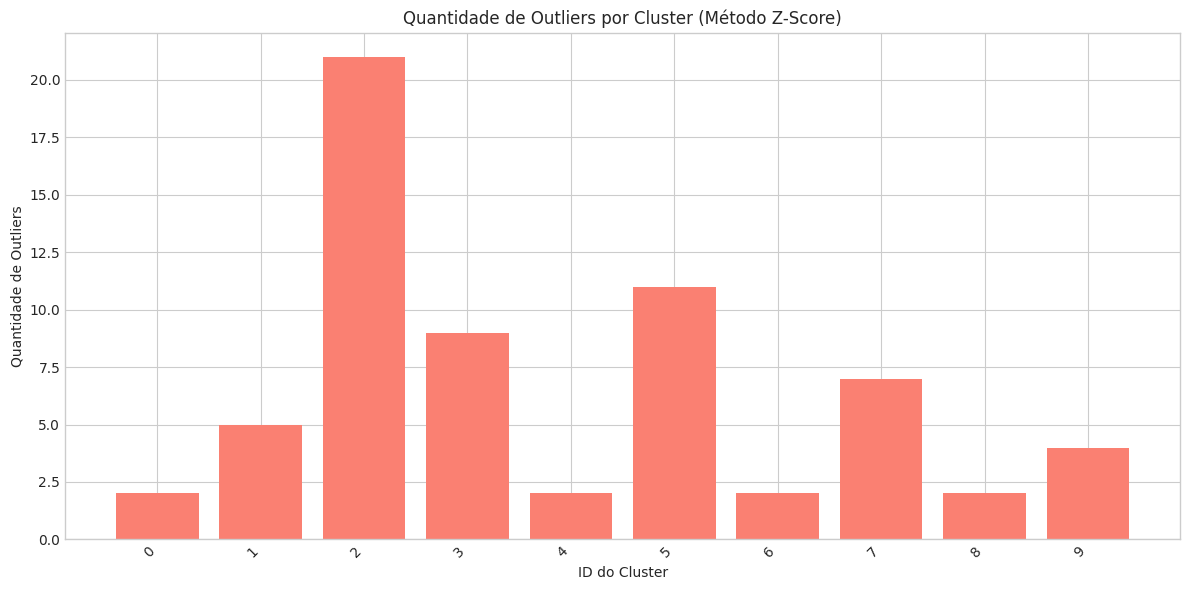


🔍 Concluída a análise de outliers por cluster.


In [ ]:
print("--- Célula 19: Iniciando Detecção de Outliers por Cluster ---")

from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

# Importar bibliotecas para visualização
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # Importar Seaborn para boxplots agrupados

# Configurações para melhor visualização dos gráficos
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráfico

COLUNA_VALOR_AQUISICAO = "valor"  # Nome da coluna numérica usada

IQR_MULTIPLIER = 1.5
Z_SCORE_THRESHOLD = 3.0

# Using 'in locals()' or 'in globals()' is a more robust check
if 'df_clustered' not in locals() and 'df_clustered' not in globals() or df_clustered is None:
    print("❌ ERRO: 'df_clustered' está ausente ou não foi definido.")
elif COLUNA_VALOR_AQUISICAO not in df_clustered.columns:
    print(f"❌ ERRO: Coluna '{COLUNA_VALOR_AQUISICAO}' não existe em df_clustered.")
else:
    print(f"Iniciando detecção de outliers na coluna '{COLUNA_VALOR_AQUISICAO}'")

    # Garantir que a coluna de valor é DoubleType para cálculos
    # df_analysis será usado para IQR, Z-Score e Boxplot
    df_analysis = df_clustered.withColumn(COLUNA_VALOR_AQUISICAO, F.col(COLUNA_VALOR_AQUISICAO).cast(DoubleType()))

    # --- IQR ---
    print("▶️ Aplicando método IQR...")
    iqr_stats = df_analysis.groupBy("id_cluster").agg(
        F.expr(f"percentile_approx({COLUNA_VALOR_AQUISICAO}, 0.25)").alias("Q1"),
        F.expr(f"percentile_approx({COLUNA_VALOR_AQUISICAO}, 0.75)").alias("Q3")
    ).withColumn("IQR", F.col("Q3") - F.col("Q1")) \
     .withColumn("lower_bound", F.col("Q1") - IQR_MULTIPLIER * F.col("IQR")) \
     .withColumn("upper_bound", F.col("Q3") + IQR_MULTIPLIER * F.col("IQR"))

    df_joined = df_analysis.join(iqr_stats, on="id_cluster", how="left")

    df_iqr_outliers = df_joined.filter(
        (F.col(COLUNA_VALOR_AQUISICAO).isNotNull()) & # Garantir que o valor não é nulo
        ((F.col(COLUNA_VALOR_AQUISICAO) < F.col("lower_bound")) |
         (F.col(COLUNA_VALOR_AQUISICAO) > F.col("upper_bound")))
    )

    print("✅ Outliers detectados com IQR. Mostrando os primeiros 5:")
    df_iqr_outliers.select("id_cluster", "objeto_aquisicao", COLUNA_VALOR_AQUISICAO).show(5, truncate=100)

    # Contar outliers por cluster para o método IQR e ordenar
    iqr_outlier_counts = df_iqr_outliers.groupBy("id_cluster").count().orderBy("id_cluster")

    print("\n🔢 Quantidade de outliers por cluster (Método IQR):")
    # Exibir a tabela no console também (opcional, pode remover se quiser apenas o gráfico)
    iqr_outlier_counts.show(truncate=False)

    # --- Visualização Quantidade de Outliers IQR (gráfico de barras) ---
    try:
        # Coletar para Pandas e gerar gráfico de barras
        iqr_counts_pd = iqr_outlier_counts.toPandas()

        plt.figure(figsize=(12, 6))
        plt.bar(iqr_counts_pd['id_cluster'].astype(str), iqr_counts_pd['count'], color='skyblue')
        plt.xlabel("ID do Cluster")
        plt.ylabel("Quantidade de Outliers")
        plt.title("Quantidade de Outliers por Cluster (Método IQR)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Erro ao gerar gráfico de barras IQR: {e}")
        print("Certifique-se de que 'matplotlib' e 'pandas' estão instalados.")

# --- Visualização Boxplot por Cluster ---
    print("\nGerando boxplot por cluster...")
    try:
        # Selecionar apenas as colunas necessárias e coletar para Pandas.
        # Isso reduz o consumo de memória comparado a coletar o df_analysis inteiro se ele tiver muitas colunas.
        # Amostre antes de coletar se o dataset for muito grande!
        # Ex: df_analysis_sample = df_analysis.sample(False, 0.1, seed=42) # Amostra de 10%
        # df_boxplot_pd = df_analysis_sample.select("id_cluster", COLUNA_VALOR_AQUISICAO).toPandas()

        # Coletar todos os dados para o boxplot (adequado se o número de registros for gerenciável)
        df_boxplot_pd = df_analysis.select("id_cluster", COLUNA_VALOR_AQUISICAO).toPandas()

        # Remover linhas onde o valor da coluna de análise é nulo.
        # Para boxplots e escalas logarítmicas, também é crucial remover valores não positivos (zero ou negativos).
        print(f"Removendo registros com valor nulo ou não positivo na coluna '{COLUNA_VALOR_AQUISICAO}' para o boxplot...")
        initial_rows = df_boxplot_pd.shape[0]
        df_boxplot_pd.dropna(subset=[COLUNA_VALOR_AQUISICAO], inplace=True)
        # Manter apenas valores estritamente positivos para a escala logarítmica
        df_boxplot_pd = df_boxplot_pd[df_boxplot_pd[COLUNA_VALOR_AQUISICAO] > 0]
        rows_after_cleanup = df_boxplot_pd.shape[0]
        print(f"Removidos {initial_rows - rows_after_cleanup} registros. Restam {rows_after_cleanup} para o boxplot.")


        if not df_boxplot_pd.empty:
            # --- Ajustar Tamanho da Figura Baseado no Número de Clusters ---
            num_unique_clusters_boxplot = df_boxplot_pd['id_cluster'].nunique()
            # Ajuste o fator (ex: 0.6 a 0.8) para controlar a largura por boxplot
            fig_width = max(8, num_unique_clusters_boxplot * 0.7)
            plt.figure(figsize=(fig_width, 7))
            # --- Fim Ajuste Tamanho da Figura ---

            # Criar o boxplot usando Seaborn
            # Alterar a paleta de cores para uma qualitativa como 'tab10'
            boxplot_plot = sns.boxplot(data=df_boxplot_pd, x='id_cluster', y=COLUNA_VALOR_AQUISICAO, palette='tab10') # Alterado palette

            # --- Opcional: Adicionar swarmplot/stripplot para visualizar pontos individuais ---
            # Isso pode ser útil, mas pode deixar o gráfico lento e poluído com muitos pontos.
            # Se desejar, descomente a linha abaixo. swarmplot tenta não sobrepor os pontos.
            # sns.swarmplot(data=df_boxplot_pd, x='id_cluster', y=COLUNA_VALOR_AQUISICAO, color=".25", size=3, alpha=0.5)
            # stripplot é mais rápido mas pode sobrepor pontos.
            # sns.stripplot(data=df_boxplot_pd, x='id_cluster', y=COLUNA_VALOR_AQUISICAO', color=".3", size=2, alpha=0.3)
            # --- Fim Opcional ---


            plt.xlabel("ID do Cluster")
            plt.ylabel(COLUNA_VALOR_AQUISICAO)
            # Ajustar o título para indicar a escala logarítmica
            plt.title(f"Boxplot do {COLUNA_VALOR_AQUISICAO} por Cluster (Escala Logarítmica no Eixo Y)")

            # --- Ajustar Rotação dos Rótulos do Eixo X ---
            # Aumentar a rotação para evitar sobreposição
            plt.xticks(rotation=60, ha='right')
            # --- Fim Ajustar Rotação dos Rótulos do Eixo X ---

            plt.tight_layout() # Ajusta o layout para evitar cortes

            # --- Aplicar escala logarítmica ao eixo Y ---
            try:
                # Aplicar a escala logarítmica. Precisa ser feito após a criação do plot.
                plt.yscale('log')
                print("Aplicado escala logarítmica ao eixo Y do boxplot.")
            except Exception as scale_e:
                print(f"⚠️ Aviso: Não foi possível aplicar escala logarítmica ao eixo Y. Verifique os dados para valores <= 0. Erro: {scale_e}")
                # Se a escala logarítmica falhar (ex: devido a zeros), a plotagem continuará com escala linear.


            # Exibir o gráfico
            # Em ambientes como Databricks, pode ser necessário usar display(plt.gcf())
            plt.show()
        else:
            print("⚠️ DataFrame para boxplot está vazio após remover valores nulos e não positivos.")

    except Exception as e:
        print(f"❌ ERRO ao gerar o boxplot: {e}")
        import traceback
        print(traceback.format_exc())
        print("Certifique-se de que 'seaborn', 'matplotlib' e 'pandas' estão instalados e que a memória do driver é suficiente para coletar os dados.")

    # --- O restante do código (Z-SCORE, etc.) continua aqui ---
    print("\n▶️ Aplicando método Z-Score...")
    # ... (seu código Z-SCORE) ...

    # --- Z-SCORE ---
    print("\n▶️ Aplicando método Z-Score...")
    window_cluster = Window.partitionBy("id_cluster")

    # Calcular média e desvio padrão por cluster, tratando possíveis desvios de zero
    df_zscore = df_analysis.withColumn("media", F.avg(COLUNA_VALOR_AQUISICAO).over(window_cluster)) \
                           .withColumn("desvio", F.stddev(COLUNA_VALOR_AQUISICAO).over(window_cluster))

    # Calcular Z-Score, tratando casos onde o desvio padrão é zero para evitar divisão por zero
    df_zscore = df_zscore.withColumn("zscore",
        F.when(F.col("desvio") == 0, 0.0) # Z-score é 0 se o desvio padrão for 0
        .otherwise((F.col(COLUNA_VALOR_AQUISICAO) - F.col("media")) / F.col("desvio"))
    ) \
     .withColumn("is_outlier_z", F.abs(F.col("zscore")) > Z_SCORE_THRESHOLD)


    df_z_outliers = df_zscore.filter("is_outlier_z")

    print("✅ Outliers detectados com Z-Score. Mostrando os primeiros 5:")
    df_z_outliers.select("id_cluster", "objeto_aquisicao", COLUNA_VALOR_AQUISICAO, "zscore").show(5, truncate=100)

    # Contar outliers por cluster para o método Z-Score e ordenar
    z_outlier_counts = df_z_outliers.groupBy("id_cluster").count().orderBy("id_cluster")

    print("\n🔢 Quantidade de outliers por cluster (Método Z-Score):")
    # Exibir a tabela no console também (opcional)
    z_outlier_counts.show(truncate=False)

    # --- Visualização Quantidade de Outliers Z-Score (gráfico de barras) ---
    try:
        # Coletar para Pandas e gerar gráfico de barras
        z_counts_pd = z_outlier_counts.toPandas()

        plt.figure(figsize=(12, 6))
        plt.bar(z_counts_pd['id_cluster'].astype(str), z_counts_pd['count'], color='salmon')
        plt.xlabel("ID do Cluster")
        plt.ylabel("Quantidade de Outliers")
        plt.title("Quantidade de Outliers por Cluster (Método Z-Score)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Erro ao gerar gráfico de barras Z-Score: {e}")
        print("Certifique-se de que 'matplotlib' e 'pandas' estão instalados e que a contagem não é excessivamente grande para coletar.")


    print("\n🔍 Concluída a análise de outliers por cluster.")


--- Célula 18_CONTINUACAO: Iniciando Detecção de Outliers por Cluster (Isolation Forest) - Abordagem Iterativa ---
Iniciando análise de outliers com Isolation Forest (Abordagem Iterativa) para a coluna 'valor'.
Parâmetros: Contaminação (IF_CONTAMINATION) = auto, Limiar Percentil Score = 0.05
AVISO: Esta abordagem coleta dados por cluster no driver e pode ser lenta/consumir muita memória para muitos clusters ou clusters grandes.
Coletando IDs de cluster únicos...
Encontrados 10 clusters únicos.
Processando Isolation Forest iterativamente por cluster...
[1/10] Processando Cluster ID: 3
[2/10] Processando Cluster ID: 1
[3/10] Processando Cluster ID: 9
[4/10] Processando Cluster ID: 6
[5/10] Processando Cluster ID: 7
[6/10] Processando Cluster ID: 0
[7/10] Processando Cluster ID: 8
[8/10] Processando Cluster ID: 5
[9/10] Processando Cluster ID: 2
[10/10] Processando Cluster ID: 4

Juntando resultados do Isolation Forest de volta ao DataFrame principal...
INFO: Removendo colunas existentes

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/root/.ipykernel/1167/command-212633846056448-818435545:357: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


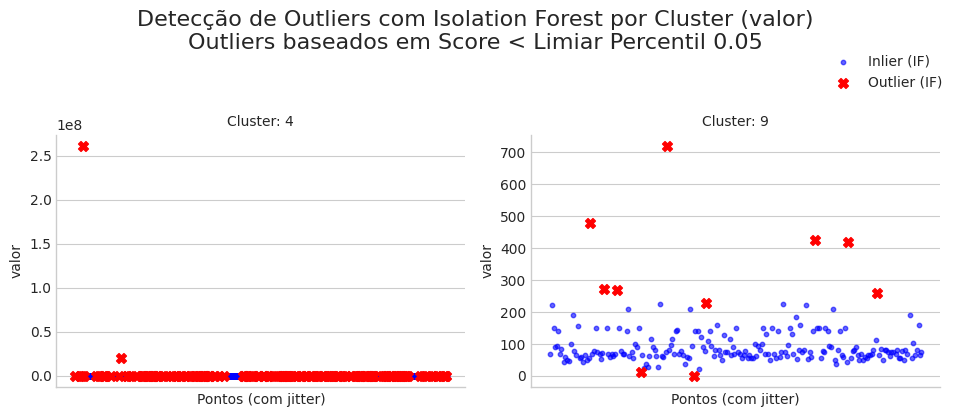

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/root/.ipykernel/1167/command-212633846056448-818435545:387: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


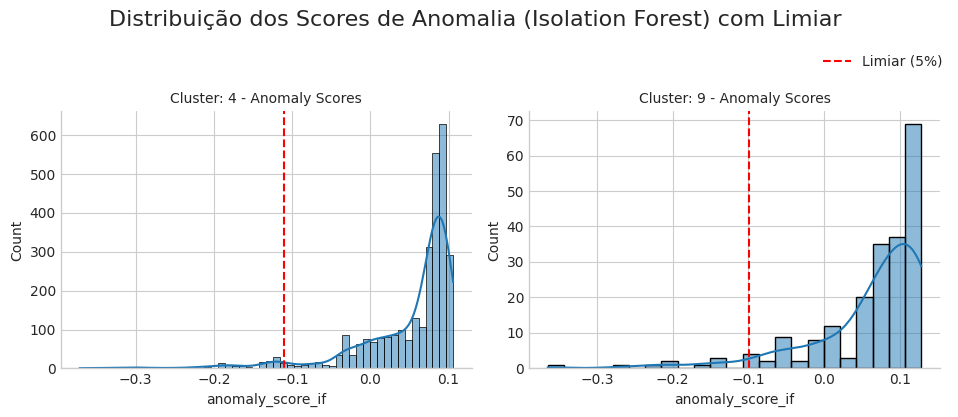


--- Célula 18_CONTINUACAO / Célula 19: Detecção de Outliers (Isolation Forest) Concluída ---


In [ ]:
# Célula 18_CONTINUACAO / Célula 19: Detecção de Outliers por Cluster (Isolation Forest) - Abordagem Iterativa

print("\n--- Célula 18_CONTINUACAO: Iniciando Detecção de Outliers por Cluster (Isolation Forest) - Abordagem Iterativa ---")

from pyspark.sql.functions import col, monotonically_increasing_id, lit, when
from pyspark.sql import functions as F # Certifique-se que F está importado
from pyspark.sql.types import StructType, StructField, DoubleType, BooleanType, LongType
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

# Importar bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce # Necessário para unionByName

# Configurações para melhor visualização dos gráficos
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráfico

# -----------------------------------------------------------------------------
# PARÂMETROS DE CONFIGURAÇÃO - AJUSTE CONFORME NECESSÁRIO
# -----------------------------------------------------------------------------
# COLUNA_VALOR_AQUISICAO já deve estar definida na Célula 18
# Ex: COLUNA_VALOR_AQUISICAO = "valor"

# Parâmetros para o método Isolation Forest
IF_N_ESTIMATORS = 100
IF_RANDOM_STATE = 42
# Percentil dos scores de anomalia para definir o limiar de outlier no Spark.
# Scores mais baixos do decision_function são mais anômalos.
# Ex: 0.05 significa que os 5% menores scores são considerados outliers.
IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD = 0.05
# Contamination para o modelo scikit-learn. 'auto' usa o limiar do modelo.
# Como usaremos um limiar baseado em percentil no Spark, este parâmetro no fit
# define mais o comportamento interno do modelo do que o limiar final de outlier.
IF_CONTAMINATION = 'auto' # Ou um float (ex: 0.05) ou 'auto'
# -----------------------------------------------------------------------------

# Verificar se o DataFrame da célula anterior está disponível
if 'df_analysis' not in locals() and 'df_analysis' not in globals() or df_analysis is None:
    print(f"❌ ERRO: DataFrame 'df_analysis' não está definido. Execute a Célula 18 primeiro.")
elif COLUNA_VALOR_AQUISICAO not in df_analysis.columns:
    print(f"❌ ERRO: A coluna de valor '{COLUNA_VALOR_AQUISICAO}' não existe no DataFrame 'df_analysis'.")
else:
    print(f"Iniciando análise de outliers com Isolation Forest (Abordagem Iterativa) para a coluna '{COLUNA_VALOR_AQUISICAO}'.")
    print(f"Parâmetros: Contaminação (IF_CONTAMINATION) = {IF_CONTAMINATION}, Limiar Percentil Score = {IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD}")
    print("AVISO: Esta abordagem coleta dados por cluster no driver e pode ser lenta/consumir muita memória para muitos clusters ou clusters grandes.")

    # Adicionar um ID único globalmente que manteremos para juntar os resultados depois.
    # Isso é crucial para garantir que os scores se juntem às linhas corretas.
    df_with_id = df_analysis.withColumn("temp_id_for_join", monotonically_increasing_id())

    # Obter a lista de IDs de cluster únicos
    print("Coletando IDs de cluster únicos...")
    cluster_ids = [row.id_cluster for row in df_with_id.select("id_cluster").distinct().collect()]
    print(f"Encontrados {len(cluster_ids)} clusters únicos.")

    # Lista para armazenar os resultados de cada cluster processado
    results_dfs_list = []

    print("Processando Isolation Forest iterativamente por cluster...")

    # --- Loop Iterativo por Cluster ---
    for i, cid in enumerate(cluster_ids):
        print(f"[{i+1}/{len(cluster_ids)}] Processando Cluster ID: {cid}")

        try:
            # 1. Filtrar o DataFrame Spark para o cluster atual
            df_cluster_spark = df_with_id.filter(col("id_cluster") == cid)

            # 2. Selecionar as colunas relevantes e coletar para Pandas
            # Incluir temp_id_for_join para juntar os resultados depois
            df_cluster_pd = df_cluster_spark.select("temp_id_for_join", COLUNA_VALOR_AQUISICAO).toPandas()

            # 3. Limpar NaNs/Infs nos dados coletados para análise
            data_to_analyze_pd = df_cluster_pd.copy()
            data_to_analyze_pd.dropna(subset=[COLUNA_VALOR_AQUISICAO], inplace=True)
            data_to_analyze_pd = data_to_analyze_pd[~data_to_analyze_pd[COLUNA_VALOR_AQUISICAO].isin([float('inf'), float('-inf')])]

            # 4. Aplicar Isolation Forest no Pandas DataFrame
            min_samples_for_if = 5 # Limiar mínimo de dados para tentar treinar
            if data_to_analyze_pd.shape[0] < min_samples_for_if:
                print(f"   Cluster {cid}: Dados insuficientes para IF ({data_to_analyze_pd.shape[0]} < {min_samples_for_if}). Pulando treinamento.")
                # Criar um resultado vazio ou com NAs para este cluster, mas com todos os IDs originais
                result_pd = df_cluster_pd[["temp_id_for_join"]].copy()
                result_pd["anomaly_score_if"] = pd.NA # Usar Pandas NA para valores nulos
            else:
                try:
                    model_if = IsolationForest(n_estimators=IF_N_ESTIMATORS,
                                               contamination=IF_CONTAMINATION,
                                               random_state=IF_RANDOM_STATE,
                                               max_features=1) # Para 1D data

                    # Treinar o modelo
                    model_if.fit(data_to_analyze_pd[[COLUNA_VALOR_AQUISICAO]].values)

                    # Calcular scores de anomalia (decision_function)
                    scores = model_if.decision_function(data_to_analyze_pd[[COLUNA_VALOR_AQUISICAO]].values)

                    # Criar um DataFrame Pandas com os resultados para os dados analisados
                    scores_pd = pd.DataFrame({
                        'temp_id_for_join': data_to_analyze_pd['temp_id_for_join'],
                        'anomaly_score_if': scores
                    })

                    # Juntar scores de volta ao DataFrame original do cluster para incluir linhas com NaN/Inf
                    result_pd = df_cluster_pd[["temp_id_for_join"]].copy()
                    result_pd = result_pd.merge(scores_pd, on="temp_id_for_join", how="left")
                    result_pd['anomaly_score_if'] = result_pd['anomaly_score_if'].astype(pd.Float64Dtype()) # Garantir tipo nullable

                except Exception as e_if_train:
                    print(f"   Cluster {cid}: Erro durante treinamento/aplicação do IF: {e_if_train}")
                    # Criar resultado com NAs em caso de erro interno
                    result_pd = df_cluster_pd[["temp_id_for_join"]].copy()
                    result_pd["anomaly_score_if"] = pd.NA


            # 5. Converter o resultado do cluster de volta para Spark DataFrame e adicionar à lista
            if not result_pd.empty:
                result_pd['id_cluster'] = cid # Adicionar a coluna de volta para este cluster
                result_spark_schema = StructType([
                    StructField("temp_id_for_join", LongType(), False),
                    StructField("anomaly_score_if", DoubleType(), True),
                    StructField("id_cluster", df_analysis.schema["id_cluster"].dataType, False) # Usar o tipo original do id_cluster
                ])
                result_df_spark = spark.createDataFrame(result_pd, schema=result_spark_schema)
                results_dfs_list.append(result_df_spark)
            else:
                print(f"   Cluster {cid}: DataFrame de resultado vazio após processamento.")

        except Exception as e_cluster:
            print(f"❌ ERRO ao processar o Cluster ID {cid}: {e_cluster}")
            import traceback
            print(traceback.format_exc())
            # Continuar para o próximo cluster


    # --- Combinar Resultados de Todos os Clusters ---
    df_if_results = None
    if results_dfs_list:
        if len(results_dfs_list) == 1:
            df_if_results = results_dfs_list[0]
        else:
            try:
                df_if_results = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), results_dfs_list)
            except Exception as union_e:
                print(f"❌ ERRO ao combinar resultados de clusters: {union_e}")


    # --- Juntar Resultados de Volta ao DataFrame Principal ---
    if df_if_results is not None:
        print("\nJuntando resultados do Isolation Forest de volta ao DataFrame principal...")

        df_left_for_join = df_with_id

        # Se 'anomaly_score_if' (ou outras colunas calculadas) existir no DataFrame à esquerda (df_with_id),
        # remove para previnir ambiguidade com a nova coluna de df_if_results.
        # Isso garante que os novos scores sejam usados.
        cols_to_drop_from_left = []
        if "anomaly_score_if" in df_left_for_join.columns:
            cols_to_drop_from_left.append("anomaly_score_if")
        if "if_score_threshold" in df_left_for_join.columns:
            cols_to_drop_from_left.append("if_score_threshold")
        if "is_outlier_if" in df_left_for_join.columns:
            cols_to_drop_from_left.append("is_outlier_if")

        if cols_to_drop_from_left:
            print(f"INFO: Removendo colunas existentes {cols_to_drop_from_left} do DataFrame principal antes de adicionar/recalcular resultados do IF.")
            df_left_for_join = df_left_for_join.drop(*cols_to_drop_from_left)

        # Agora junte. df_left_for_join tem garantia de não ter 'anomaly_score_if'.
        # O 'anomaly_score_if' selecionado de df_if_results será o único.
        df_analysis = df_left_for_join.join(
            df_if_results.select("temp_id_for_join", "anomaly_score_if"),
            "temp_id_for_join", # Chave do Join
            "left"
        )

        # Remover o ID temporário do join.
        df_analysis = df_analysis.drop("temp_id_for_join")


        # --- Calcular Limiar e Definir Outliers no Spark ---
        print("\nCalculando limiar de outlier Isolation Forest baseado em percentil do score por cluster no Spark...")
        from pyspark.sql.window import Window
        window_spec_cluster = Window.partitionBy("id_cluster")

        df_analysis = df_analysis.withColumn(
            "if_score_threshold",
            F.expr(f"percentile_approx(anomaly_score_if, {IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD}, 10000)")
            .over(window_spec_cluster)
        )

        df_analysis = df_analysis.withColumn(
            "is_outlier_if",
            (F.col("anomaly_score_if").isNotNull()) & \
            (F.col("if_score_threshold").isNotNull()) & \
            (F.col("anomaly_score_if") < F.col("if_score_threshold"))
        )

        print("Cálculo de outliers Isolation Forest (baseado em percentil no Spark) concluído.")

        # --- Exibição dos Resultados do Isolation Forest ---
        print("\n--- Resultados da Detecção de Outliers (Isolation Forest) ---")

        print(f"\n🔢 Quantidade de outliers por cluster (Método Isolation Forest - Score < Limiar Percentil {IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD}):")
        # Este if_outlier_counts será usado para selecionar clusters para plotagem
        if_outlier_counts = df_analysis.groupBy("id_cluster") \
            .agg(F.sum(F.when(F.col("is_outlier_if") == True, 1).otherwise(0)).alias("outlier_count")) \
            .orderBy("id_cluster")
        if_outlier_counts.show(truncate=False)

        print("\nContagem total por cluster (Inliers vs Outliers IF - Baseado em Percentil Score):")
        df_analysis.groupBy("id_cluster", "is_outlier_if") \
            .count() \
            .orderBy("id_cluster", "is_outlier_if") \
            .show(truncate=False)


        print(f"\nAmostra de outliers identificados pelo Isolation Forest (coluna '{COLUNA_VALOR_AQUISICAO}' - Baseado em Percentil Score):")
        colunas_para_mostrar_outliers_if = ["id_cluster", COLUNA_VALOR_AQUISICAO, "anomaly_score_if", "if_score_threshold", "is_outlier_if"]
        if "objeto_aquisicao" in df_analysis.columns:
            if "objeto_aquisicao" not in colunas_para_mostrar_outliers_if:
                colunas_para_mostrar_outliers_if.insert(colunas_para_mostrar_outliers_if.index(COLUNA_VALOR_AQUISICAO), "objeto_aquisicao")

        df_analysis.filter(F.col("is_outlier_if") == True) \
            .select([col_name for col_name in colunas_para_mostrar_outliers_if if col_name in df_analysis.columns]) \
            .show(10, truncate=False)

        print("\nDataFrame 'df_analysis' agora contém as colunas de detecção de outliers Isolation Forest (score e flag final):")
        df_analysis.printSchema()

    else:
        print("❌ Não foi possível juntar os resultados do Isolation Forest, pois nenhum cluster foi processado com sucesso ou df_if_results está vazio.")


    # --- Visualização dos Resultados do Isolation Forest ---
    print("\n--- Visualização dos Outliers (Isolation Forest) ---")

    clusters_para_plotar = []
    # Certifique-se que df_analysis e if_outlier_counts (calculado acima) estão disponíveis
    if 'df_analysis' in locals() and df_analysis is not None and \
       'is_outlier_if' in df_analysis.columns and \
       'if_outlier_counts' in locals() and if_outlier_counts is not None:

        if if_outlier_counts.count() > 0:
            # Determinar cluster com mais outliers
            # Usar F.asc("id_cluster") como desempate para consistência
            cluster_most_outliers_row = if_outlier_counts.orderBy(F.desc("outlier_count"), F.asc("id_cluster")).first()
            cluster_most_outliers_id = cluster_most_outliers_row["id_cluster"]

            # Determinar cluster com menos outliers
            # Usar F.asc("id_cluster") como desempate para consistência
            cluster_least_outliers_row = if_outlier_counts.orderBy(F.asc("outlier_count"), F.asc("id_cluster")).first()
            cluster_least_outliers_id = cluster_least_outliers_row["id_cluster"]

            clusters_para_plotar = [cluster_most_outliers_id, cluster_least_outliers_id]
            # Remove duplicatas se mais e menos outliers estiverem no mesmo cluster e ordena
            clusters_para_plotar = sorted(list(dict.fromkeys(clusters_para_plotar)))

            print(f"Selecionado para plotagem o cluster com MAIS outliers: ID {cluster_most_outliers_id} (Contagem: {cluster_most_outliers_row['outlier_count']})")
            print(f"Selecionado para plotagem o cluster com MENOS outliers: ID {cluster_least_outliers_id} (Contagem: {cluster_least_outliers_row['outlier_count']})")
            print(f"Clusters finais para plotagem: {clusters_para_plotar}")
        else:
            print("⚠️ 'if_outlier_counts' está vazio. Não é possível determinar clusters para plotagem.")
    else:
        print("⚠️ 'df_analysis' não está pronto ou 'if_outlier_counts' não foi calculado. Não é possível determinar clusters para plotagem.")

    if clusters_para_plotar:
        print(f"Gerando gráficos para os clusters selecionados: {clusters_para_plotar}")

        max_points_per_cluster_for_plot = 3000 # Ajuste conforme necessário

        dfs_to_plot_list = []
        for cid_plot in clusters_para_plotar:
            df_cluster_data = df_analysis.filter(col("id_cluster") == cid_plot)
            count_cluster = df_cluster_data.count()

            if count_cluster > 0:
                if count_cluster > max_points_per_cluster_for_plot:
                    sample_fraction = max_points_per_cluster_for_plot / count_cluster
                    df_cluster_sample = df_cluster_data.sample(withReplacement=False, fraction=sample_fraction, seed=IF_RANDOM_STATE)
                else:
                    df_cluster_sample = df_cluster_data

                cols_for_plot = ["id_cluster", COLUNA_VALOR_AQUISICAO, "is_outlier_if"]
                if "anomaly_score_if" in df_analysis.columns:
                    cols_for_plot.append("anomaly_score_if")
                if "if_score_threshold" in df_analysis.columns:
                    cols_for_plot.append("if_score_threshold")

                cols_to_select_plot = [c for c in cols_for_plot if c in df_cluster_sample.columns]
                if cols_to_select_plot: # Only append if there are columns to select
                    dfs_to_plot_list.append(df_cluster_sample.select(cols_to_select_plot))

        df_for_plot_spark = None
        if dfs_to_plot_list:
            if len(dfs_to_plot_list) == 1:
                df_for_plot_spark = dfs_to_plot_list[0]
            else:
                try:
                    df_for_plot_spark = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), dfs_to_plot_list)
                except Exception as union_e:
                    print(f"⚠️ Erro ao combinar dataframes amostrados para plotagem: {union_e}")
                    df_for_plot_spark = None

        if df_for_plot_spark is not None:
            try:
                print("Coletando dados amostrados para plotagem (pode levar um tempo)...")
                df_plot_pd = df_for_plot_spark.toPandas()

                essential_plot_cols = [COLUNA_VALOR_AQUISICAO, 'is_outlier_if']
                # Check if all essential columns are present
                if not all(c in df_plot_pd.columns for c in essential_plot_cols):
                    print(f"❌ ERRO: Colunas essenciais para plotagem ({essential_plot_cols}) não encontradas em df_plot_pd após coleta. Colunas disponíveis: {df_plot_pd.columns.tolist()}")
                else:
                    df_plot_pd.dropna(subset=essential_plot_cols, inplace=True)

                    if not df_plot_pd.empty:
                        # Scatter Plot (Inliers vs Outliers)
                        g = sns.FacetGrid(df_plot_pd, col="id_cluster", col_wrap=len(clusters_para_plotar) if clusters_para_plotar else 1, sharex=False, sharey=False, height=4, aspect=1.2)

                        def facet_scatter_if(data, **kwargs):
                            x_values_jitter = data.index.to_series().apply(lambda x_val: x_val + np.random.uniform(-0.3, 0.3))
                            data_local = data.copy()
                            data_local[COLUNA_VALOR_AQUISICAO] = pd.to_numeric(data_local[COLUNA_VALOR_AQUISICAO], errors='coerce')
                            data_local.dropna(subset=[COLUNA_VALOR_AQUISICAO], inplace=True)

                            outliers = data_local[data_local["is_outlier_if"] == True]
                            inliers = data_local[data_local["is_outlier_if"] == False]

                            if not inliers.empty:
                                plt.scatter(x_values_jitter.loc[inliers.index], inliers[COLUNA_VALOR_AQUISICAO],
                                            color='blue', alpha=0.6, s=10, label='Inlier (IF)')
                            if not outliers.empty:
                                plt.scatter(x_values_jitter.loc[outliers.index], outliers[COLUNA_VALOR_AQUISICAO],
                                            color='red', marker='X', s=50, label='Outlier (IF)')
                            plt.xticks([])
                            plt.xlabel("Pontos (com jitter)")
                            plt.ylabel(COLUNA_VALOR_AQUISICAO)

                        g.map_dataframe(facet_scatter_if)

                        handles, labels = [], []
                        for ax in g.axes.flat:
                            h_ax, l_ax = ax.get_legend_handles_labels()
                            for handle, label in zip(h_ax, l_ax):
                                if label not in labels:
                                    handles.append(handle)
                                    labels.append(label)
                        if handles:
                             g.fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.95))

                        g.set_titles("Cluster: {col_name}")
                        g.fig.suptitle(f'Detecção de Outliers com Isolation Forest por Cluster ({COLUNA_VALOR_AQUISICAO})\nOutliers baseados em Score < Limiar Percentil {IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD}',
                                        y=1.03, fontsize=16)
                        plt.tight_layout(rect=[0, 0, 1, 0.95])
                        plt.show()

                        # Histograma dos Scores de Anomalia
                        if 'anomaly_score_if' in df_plot_pd.columns and 'if_score_threshold' in df_plot_pd.columns:
                            df_plot_pd_scores_with_threshold = df_plot_pd.dropna(subset=['anomaly_score_if', 'if_score_threshold'])
                            if not df_plot_pd_scores_with_threshold.empty:
                                g_scores = sns.FacetGrid(df_plot_pd_scores_with_threshold, col="id_cluster", col_wrap=len(clusters_para_plotar) if clusters_para_plotar else 1, sharex=False, sharey=False, height=4, aspect=1.2)
                                g_scores.map(sns.histplot, "anomaly_score_if", kde=True)

                                def plot_threshold_line(data, **kwargs):
                                    if not data.empty and 'if_score_threshold' in data.columns:
                                        threshold_value = data['if_score_threshold'].iloc[0]
                                        if pd.notna(threshold_value):
                                            plt.axvline(threshold_value, color='red', linestyle='--', label=f'Limiar ({IF_ANOMALY_SCORE_PERCENTILE_THRESHOLD*100:.0f}%)')

                                g_scores.map_dataframe(plot_threshold_line)

                                handles_thresh, labels_thresh = [], []
                                for ax_score in g_scores.axes.flat:
                                    h_ax_s, l_ax_s = ax_score.get_legend_handles_labels()
                                    for handle, label in zip(h_ax_s, l_ax_s):
                                        if label not in labels_thresh:
                                            handles_thresh.append(handle)
                                            labels_thresh.append(label)
                                if handles_thresh:
                                    g_scores.fig.legend(handles_thresh, labels_thresh, loc='upper right', bbox_to_anchor=(1.0, 0.95))

                                g_scores.set_titles("Cluster: {col_name} - Anomaly Scores")
                                g_scores.fig.suptitle(f'Distribuição dos Scores de Anomalia (Isolation Forest) com Limiar', y=1.03, fontsize=16)
                                plt.tight_layout(rect=[0, 0, 1, 0.95])
                                plt.show()
                            else:
                                print("⚠️ DataFrame de scores com limiar para plotagem está vazio após limpeza de NaNs.")
                        else:
                            print("⚠️ Colunas 'anomaly_score_if' ou 'if_score_threshold' não encontradas no DataFrame para plotagem de scores com limiar.")
                    else:
                        print("⚠️ DataFrame para plotagem está vazio após limpeza de NaNs. Nenhuma visualização gerada.")
            except Exception as e_plot_collect:
                print(f"❌ ERRO ao coletar dados amostrados ou plotar: {e_plot_collect}")
                import traceback
                print(traceback.format_exc())
        else:
            print("⚠️ Nenhum DataFrame preparado para plotagem após amostragem e combinação.")
    else:
        print("⚠️ Nenhum cluster selecionado para gerar visualizações.")

print("\n--- Célula 18_CONTINUACAO / Célula 19: Detecção de Outliers (Isolation Forest) Concluída ---")